### CONDA ENVIRONMENTS

For steps __1. preprocess__ and __2. mip__, `conda activate g5ht-pipeline`

For step __3. segment__, `conda activate segment-torch` or `conda activate torchcu129`

For step __4. spline, 5. orient, 6. warp, 7. reg__

## TODO:

1. I wonder if I computed a spline on each and every z slice and warped each, oriented each of them, and warped each of them, if the problem of weirdly sheared image stacks would be solved
2. quick mp4 for all recordings
   1. now working in engaging, works per one nd2 sbatch
3. focus check for all recordings
   1. maybe focus check can be used to specify which z slices are good to use and which frames are good to use
4. for recordings starting in december 2025, need to trim first 2 rather than last 2 z slices
5. flip worms so that VNC is always up
6. fixed mask could be automated, but if not, make sure to save which index is fixed
7. extract behavior
8. posture similarity
   1. posture might consist of the spline + thresholded z-stack
      1. I'm thinking that the orientation shouldn't matter, but the z-planes in focus will, and curvature/spline of the head will
      2. maybe need to actually interpolate to 117 z slices
   2. sub registration problems
   3. label each set of registered frames with one set of ROIs, or auto segment ROIs from each set of registered frames
9.  track z over time, which zslices are consistent
   1. focus + correlation
10. beads -> train/test
11. gfp+1 relative to rfp channel (might only apply to pre december 2025 recordings)
12. wholistic 
    1.  parameter sweep, might change
    2.  python version
13. autocorr/scorr
14. automate z slice trimming
    1.  pre december 2025 (trim last 2 z slices)
    2.  post december 2025 (trim first z slice)
15. photobleaching estimation?
    1.  record immo with serotonin
    2.  at least do it for RFP
16. try deltaF/F [ (F(t) - F0) / F0 ]
17. coding directions (preencounter-baseline) (postencounter-baseline)
    1.  then show voxel weights
18. port everything to engaging

In [1]:
import sys
import os
import importlib
from tqdm import tqdm

try:
    import utils
    is_torch_env = False
except ImportError:
    is_torch_env = True
    print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

## SPECIFY DATA TO PROCESS

In [24]:
DATA_PTH = r'C:\Users\munib\POSTDOC\DATA'
PROJECT = 'g5ht-free' # g5ht-free or g5ht-immo
DATE = '20260206'

DATA_PTH = os.path.join(DATA_PTH, PROJECT, DATE)


INPUT_ND2 = 'date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003.nd2'

INPUT_ND2_PTH = os.path.join(DATA_PTH, INPUT_ND2)

NOISE_PTH = r'C:\Users\munib\POSTDOC\CODE\g5ht-pipeline\noise\noise_111125.tif'

OUT_DIR = os.path.splitext(INPUT_ND2_PTH)[0]

STACK_LENGTH = 41 if 'immo' not in INPUT_ND2 else 122

# if not is_torch_env:
#     noise_stack = utils.get_noise_stack(NOISE_PTH, STACK_LENGTH)
#     num_frames, height, width, num_channels = utils.get_range_from_nd2(INPUT_ND2_PTH, stack_length=STACK_LENGTH) 
#     beads_alignment_file = utils.get_beads_alignment_file(INPUT_ND2_PTH)
# else:
#     print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

# print(INPUT_ND2)
# print('Num z-slices: ', STACK_LENGTH)
# if not is_torch_env:
#     print('Number of frames: ', num_frames)
#     print('Height: ', height)
#     print('width: ', width)
#     print('Number of channels: ', num_channels)
#     print('Beads alignment file: ', beads_alignment_file)

## 10. LABEL ROIs

`conda activate g5ht-pipeline`

- after this step, use `lbl` conda env to label ROI of fixed frame
  - run `labelme` in terminal


maybe also see here for video annotation: https://github.com/wkentaro/labelme/tree/main/examples/video_annotation

__LABELS__:


> ['ventral_nerve_cord', 'nerve_ring', 'isthmus', 'procorpus', 'dorsal_nerve_cord', 'terminal_bulb', 'metacorpus']
>
> it  might not be possible to see the dorsal nerve cord after looking at this more

### EXPORT FIXED VOLUME AS PNGs for labeling with `labelme`

In [ ]:
# code that exports each z-slice of fixed.tif as a separate png
# save as cell below, but for all recording in g5ht-free folder
import tifffile
import os
import glob
import scipy.ndimage as ndi
import numpy as np


# loop over all recordings
DATA_PTH = r'D:\DATA\g5ht-free'
worm_tuple = ('worm001', 'worm002', 'worm003', 'worm004', 'worm005', 'worm006', 'worm007', 'worm008', 'worm009', 'worm010', 'worm011')

date_pths = [os.path.join(DATA_PTH, d) for d in os.listdir(DATA_PTH) if os.path.isdir(os.path.join(DATA_PTH, d))]

# in each folder in date_pths, look for folders that end with 'wormXXX', where XXX is a three digit number, and then look for the 'registered_elastix' folder inside that folder to create the mp4
for date_pth in date_pths:
    print(date_pth)
    worm_pths = [os.path.join(date_pth, d) for d in os.listdir(date_pth) if os.path.isdir(os.path.join(date_pth, d)) and d.endswith(worm_tuple)]
    print(worm_pths)
    for worm_pth in worm_pths:
        

        PTH = worm_pth

        # in PTH directory, find a fixed_XXXX*.tif file, where XXXX are digits
        fixed_list= glob.glob(os.path.join(PTH, 'fixed_[0-9][0-9][0-9][0-9]*.tif'))
        if len(fixed_list) == 0:
            print(f"No fixed_XXXX*.tif file found in {PTH}, skipping...")
            continue
        fixed_fn = fixed_list[0]
        fixed_pth = os.path.join(PTH, fixed_fn)

        # fixed_pth = os.path.join(PTH, 'fixed.tif')
        # fixed_stack = ndi.zoom(tifffile.imread(fixed_pth), zoom=(3,1,1,1))
        fixed_stack = tifffile.imread(fixed_pth)

        out_dir = os.path.join(PTH, 'fixed_png')
        if os.path.exists(out_dir):
            print(f"{out_dir} already exists, skipping saving pngs for {fixed_pth}")
            continue
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

        for i in range(fixed_stack.shape[0]):
            slice_pth = os.path.join(out_dir, f'fixed_z{i:02d}.png')
            # make sure to save channel 1, and that it is visible, correct data type, clipped to 0-255
            slice_img = fixed_stack[i,1,:,:]
            # slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
            slice_img = np.clip(slice_img, 0, 255)
            slice_img = slice_img.astype('uint8')
            tifffile.imwrite(slice_pth, slice_img) 

        out_dir = os.path.join(PTH, 'fixed_xz_png')
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

        for i in range(fixed_stack.shape[2]):
            slice_pth = os.path.join(out_dir, f'fixed_xz{i:02d}.png')
            # make sure to save channel 1, and that it is visible, correct data type, clipped to 0-255
            slice_img = fixed_stack[:,1,i,:]
            slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
            slice_img = slice_img.astype('uint8')
            tifffile.imwrite(slice_pth, slice_img) 

        out_dir = os.path.join(PTH, 'fixed_yz_png')
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

        for i in range(fixed_stack.shape[3]):
            slice_pth = os.path.join(out_dir, f'fixed_yz{i:02d}.png')
            # make sure to save channel 1, and that it is visible, correct data type, clipped to 0-255
            slice_img = fixed_stack[:,1,:,i]
            slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
            slice_img = slice_img.astype('uint8')
            # save as high quality tiff
            tifffile.imwrite(slice_pth, slice_img)

        # save max projection along z
        out_dir = os.path.join(PTH, 'fixed_maxproj_png')
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        max_proj = fixed_stack.max(axis=0)
        for c in range(max_proj.shape[0]):
            slice_pth = os.path.join(out_dir, f'fixed_maxproj_c{c:02d}.png')
            # make sure to save channel c, and that it is visible, correct data type, clipped to 0-255
            slice_img = max_proj[c,:,:]
            slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
            slice_img = slice_img.astype('uint8')
            tifffile.imwrite(slice_pth, slice_img)

D:\DATA\g5ht-free\022025_eft_41z_starved_worm002
['D:\\DATA\\g5ht-free\\022025_eft_41z_starved_worm002\\022025_eft_41z_starved_worm002']
No fixed_XXXX*.tif file found in D:\DATA\g5ht-free\022025_eft_41z_starved_worm002\022025_eft_41z_starved_worm002, skipping...
D:\DATA\g5ht-free\20251223
['D:\\DATA\\g5ht-free\\20251223\\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005', 'D:\\DATA\\g5ht-free\\20251223\\date-20251223_strain-ISg5HT_condition-fedpatch_worm001', 'D:\\DATA\\g5ht-free\\20251223\\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004']
D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\fixed_png already exists, skipping saving pngs for D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\fixed_1080.tif


C:\Users\munib\AppData\Local\Temp\ipykernel_37420\957361770.py:73: RuntimeWarning: invalid value encountered in divide
  slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
C:\Users\munib\AppData\Local\Temp\ipykernel_37420\957361770.py:74: RuntimeWarning: invalid value encountered in cast
  slice_img = slice_img.astype('uint8')


D:\DATA\g5ht-free\20260123
['D:\\DATA\\g5ht-free\\20260123\\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005', 'D:\\DATA\\g5ht-free\\20260123\\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004']
D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005\fixed_png already exists, skipping saving pngs for D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005\fixed_0219.tif
D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004\fixed_png already exists, skipping saving pngs for D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004\fixed_0848.tif
D:\DATA\g5ht-free\20251028
['D:\\DATA\\g5ht-free\\20251028\\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001', 'D:\\DATA\\g5ht-free\\20251028\\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002']
D:\DATA\g5ht-free\20251028\date-20251028_time-1500_s

In [ ]:
# code that exports each z-slice of fixed.tif as a separate png
# save as cell above, but for a single recording loaded at the top of the notebook
import tifffile
import os
import glob
import scipy.ndimage as ndi
import numpy as np

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

# in PTH directory, find a fixed_XXXX*.tif file, where XXXX are digits
fixed_fn = glob.glob(os.path.join(PTH, 'fixed_[0-9][0-9][0-9][0-9]*.tif'))[0]
fixed_pth = os.path.join(PTH, fixed_fn)

# fixed_pth = os.path.join(PTH, 'fixed.tif')
# fixed_stack = ndi.zoom(tifffile.imread(fixed_pth), zoom=(3,1,1,1))
fixed_stack = tifffile.imread(fixed_pth)

out_dir = os.path.join(PTH, 'fixed_png')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for i in range(fixed_stack.shape[0]):
    slice_pth = os.path.join(out_dir, f'fixed_z{i:02d}.png')
    # make sure to save channel 1, and that it is visible, correct data type, clipped to 0-255
    slice_img = fixed_stack[i,1,:,:]
    # slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
    slice_img = np.clip(slice_img, 0, 255)
    slice_img = slice_img.astype('uint8')
    tifffile.imwrite(slice_pth, slice_img) 

out_dir = os.path.join(PTH, 'fixed_xz_png')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for i in range(fixed_stack.shape[2]):
    slice_pth = os.path.join(out_dir, f'fixed_xz{i:02d}.png')
    # make sure to save channel 1, and that it is visible, correct data type, clipped to 0-255
    slice_img = fixed_stack[:,1,i,:]
    slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
    slice_img = slice_img.astype('uint8')
    tifffile.imwrite(slice_pth, slice_img) 

out_dir = os.path.join(PTH, 'fixed_yz_png')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for i in range(fixed_stack.shape[3]):
    slice_pth = os.path.join(out_dir, f'fixed_yz{i:02d}.png')
    # make sure to save channel 1, and that it is visible, correct data type, clipped to 0-255
    slice_img = fixed_stack[:,1,:,i]
    slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
    slice_img = slice_img.astype('uint8')
    # save as high quality tiff
    tifffile.imwrite(slice_pth, slice_img)

# save max projection along z
out_dir = os.path.join(PTH, 'fixed_maxproj_png')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
max_proj = fixed_stack.max(axis=0)
for c in range(max_proj.shape[0]):
    slice_pth = os.path.join(out_dir, f'fixed_maxproj_c{c:02d}.png')
    # make sure to save channel c, and that it is visible, correct data type, clipped to 0-255
    slice_img = max_proj[c,:,:]
    slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
    slice_img = slice_img.astype('uint8')
    tifffile.imwrite(slice_pth, slice_img)

NameError: name 'INPUT_ND2_PTH' is not defined

In [26]:
# code that exports each z-slice of fixed.tif as a separate png
import tifffile
import os
import glob
import scipy.ndimage as ndi

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

# in PTH directory, find a fixed_XXXX*.tif file, where XXXX are digits
fixed_fn = glob.glob(os.path.join(PTH, 'fixed_[0-9][0-9][0-9][0-9]*.tif'))[0]
fixed_pth = os.path.join(PTH, fixed_fn)

# fixed_pth = os.path.join(PTH, 'fixed.tif')
# fixed_stack = ndi.zoom(tifffile.imread(fixed_pth), zoom=(3,1,1,1))
fixed_stack = tifffile.imread(fixed_pth)


# save max projection along z
out_dir = os.path.join(PTH, 'fixed_maxproj_png')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

mn0 = 0
mx0 = 175
mn1 = 0
mx1 = 700
max_proj = fixed_stack.max(axis=0)
for c in range(max_proj.shape[0]):
    if c==0:
        mn = mn0
        mx = mx0
    elif c==1:
        mn = mn1
        mx = mx1
    slice_pth = os.path.join(out_dir, f'fixed_maxproj_c{c:0d}.png')
    # make sure to save channel c, and that it is visible, correct data type, clipped to 0-255
    slice_img = max_proj[c,:,:]
    slice_img = (slice_img - mn) / (mx - mn) * 255
    slice_img = slice_img.astype('uint8')
    tifffile.imwrite(slice_pth, slice_img)

### PARSE OUTPUT OF `labelme`

- outputs `roi.tif`

In [30]:
import numpy as np
import json
from skimage.draw import polygon

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

out_dir = os.path.join(PTH, 'fixed_png')
fixed_fn = glob.glob(os.path.join(PTH, 'fixed_[0-9][0-9][0-9][0-9]*.tif'))[0]
fixed_pth = os.path.join(PTH, fixed_fn)
fixed_stack = tifffile.imread(fixed_pth)
Z,C,H,W = fixed_stack.shape

roi = np.zeros((Z, H, W), dtype=fixed_stack.dtype) # ZHW

# get all unique roi_labels from json files
roi_json_files = glob.glob(os.path.join(out_dir, 'fixed_z[0-9][0-9]*.json'))
roi_labels = []
for roi_json_file in roi_json_files:
    with open(roi_json_file, 'r') as f:
        roi_dict = json.load(f)
        roi_labels.append([shape['label'] for shape in roi_dict['shapes']])
# get all unique roi_labels
roi_labels = list(set([item for sublist in roi_labels for item in sublist]))
print(roi_labels)

# # roi_labels = ['PC','MC','IM','TB','NR','VNC','DNC']
# # procorpus, metacorpus, isthmus, terminal bulb, nerve ring, ventral nerve cord, dorsal nerve cord

for i in range(Z):
    slice_roi_json = os.path.join(out_dir, f'fixed_z{i:02d}.json')
    # if slice_roi_json doesn't exist, continue
    if not os.path.exists(slice_roi_json):
        continue
    with open(slice_roi_json, 'r') as f:
        roi_dict = json.load(f)
        # loop through each shape in roi_dict['shapes']
        for shape in roi_dict['shapes']:
            label = shape['label']
            if label in roi_labels:
                points = shape['points']
                # get integer coordinates
                points = [(int(round(p[1])), int(round(p[0]))) for p in points]
                # create a mask for the polygon
                
                rr, cc = polygon([p[0] for p in points], [p[1] for p in points], shape=(H,W))
                # should set to correct z slice
                roi[i, rr, cc] = roi_labels.index(label) + 1 # start from 1

# save roi stack as tif image, imagej=true and save the roi labels as metadata
roi_pth = os.path.join(PTH, 'roi.tif')
tifffile.imwrite(roi_pth, roi.astype(np.uint8), imagej=True, metadata={'Labels': roi_labels})

['nerve_ring', 'terminal_bulb', 'ventral_nerve_cord', 'metacorpus', 'isthmus', 'procorpus']


In [5]:
# loop over all recordings
import os
import json
import numpy as np
import glob
import tifffile
from skimage.draw import polygon


DATA_PTH = r'D:\DATA\g5ht-free'
worm_tuple = ('worm001', 'worm002', 'worm003', 'worm004', 'worm005', 'worm006', 'worm007', 'worm008', 'worm009', 'worm010', 'worm011')


date_pths = [os.path.join(DATA_PTH, d) for d in os.listdir(DATA_PTH) if os.path.isdir(os.path.join(DATA_PTH, d))]

# in each folder in date_pths, look for folders that end with 'wormXXX', where XXX is a three digit number, and then look for the 'registered_elastix' folder inside that folder to create the mp4
for date_pth in date_pths:
    # print(date_pth)
    worm_pths = [os.path.join(date_pth, d) for d in os.listdir(date_pth) if os.path.isdir(os.path.join(date_pth, d)) and d.endswith(worm_tuple)]
    # print(worm_pths)
    for worm_pth in worm_pths:
        # check for an a *_processed_data.h5 in worm_pth
        
        PTH = worm_pth
        out_dir = os.path.join(PTH, 'fixed_png')
        fixed_list = glob.glob(os.path.join(PTH, 'fixed_[0-9][0-9][0-9][0-9]*.tif'))
        if len(fixed_list) == 0:
            print(f"No fixed_XXXX*.tif file found in {PTH}, skipping...")
            continue
        fixed_fn = fixed_list[0]
        fixed_pth = os.path.join(PTH, fixed_fn)
        fixed_stack = tifffile.imread(fixed_pth)
        Z,C,H,W = fixed_stack.shape

        roi = np.zeros((Z, H, W), dtype=fixed_stack.dtype) # ZHW

        # get all unique roi_labels from json files
        roi_json_files = glob.glob(os.path.join(out_dir, 'fixed_z[0-9][0-9]*.json'))
        roi_labels = []
        for roi_json_file in roi_json_files:
            with open(roi_json_file, 'r') as f:
                roi_dict = json.load(f)
                roi_labels.append([shape['label'] for shape in roi_dict['shapes']])
        # get all unique roi_labels
        roi_labels = list(set([item for sublist in roi_labels for item in sublist]))
        print(roi_labels)

        # # roi_labels = ['PC','MC','IM','TB','NR','VNC','DNC']
        # # procorpus, metacorpus, isthmus, terminal bulb, nerve ring, ventral nerve cord, dorsal nerve cord

        for i in range(Z):
            slice_roi_json = os.path.join(out_dir, f'fixed_z{i:02d}.json')
            # if slice_roi_json doesn't exist, continue
            if not os.path.exists(slice_roi_json):
                continue
            with open(slice_roi_json, 'r') as f:
                roi_dict = json.load(f)
                # loop through each shape in roi_dict['shapes']
                for shape in roi_dict['shapes']:
                    label = shape['label']
                    if label in roi_labels:
                        points = shape['points']
                        # get integer coordinates
                        points = [(int(round(p[1])), int(round(p[0]))) for p in points]
                        # create a mask for the polygon
                        
                        rr, cc = polygon([p[0] for p in points], [p[1] for p in points], shape=(H,W))
                        # should set to correct z slice
                        roi[i, rr, cc] = roi_labels.index(label) + 1 # start from 1

        # save roi stack as tif image, imagej=true and save the roi labels as metadata
        roi_pth = os.path.join(PTH, 'roi.tif')
        tifffile.imwrite(roi_pth, roi.astype(np.uint8), imagej=True, metadata={'Labels': roi_labels})
        
        

No fixed_XXXX*.tif file found in D:\DATA\g5ht-free\022025_eft_41z_starved_worm002\022025_eft_41z_starved_worm002, skipping...
['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
[]
['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
['metacorpus', 'terminal_bulb', 'isthmus', 'dorsal_nerve_cord', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
['metacorpus', 'terminal_bulb', 'isthmus', 'mtea', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
['metacorpus', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
['metacorpus', 'terminal_bulb',

### get nerve ring roi for diffusion example dataset

In [ ]:
import numpy as np
import json
from skimage.draw import polygon
import glob
import tifffile
import os

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

out_dir = os.path.join(PTH, 'fixed_png_diff_roi')
fixed_fn = glob.glob(os.path.join(PTH, 'fixed_[0-9][0-9][0-9][0-9]*.tif'))[0]
fixed_pth = os.path.join(PTH, fixed_fn)
fixed_stack = tifffile.imread(fixed_pth)
Z,C,H,W = fixed_stack.shape

roi = np.zeros((Z, H, W), dtype=fixed_stack.dtype) # ZHW

# get all unique roi_labels from json files
roi_json_files = glob.glob(os.path.join(out_dir, 'fixed_z[0-9][0-9]*.json'))
roi_labels = []
for roi_json_file in roi_json_files:
    with open(roi_json_file, 'r') as f:
        roi_dict = json.load(f)
        roi_labels.append([shape['label'] for shape in roi_dict['shapes']])
# get all unique roi_labels
roi_labels = list(set([item for sublist in roi_labels for item in sublist]))
print(roi_labels)

# # roi_labels = ['PC','MC','IM','TB','NR','VNC','DNC']
# # procorpus, metacorpus, isthmus, terminal bulb, nerve ring, ventral nerve cord, dorsal nerve cord

for i in range(Z):
    slice_roi_json = os.path.join(out_dir, f'fixed_z{i:02d}.json')
    # if slice_roi_json doesn't exist, continue
    if not os.path.exists(slice_roi_json):
        continue
    with open(slice_roi_json, 'r') as f:
        roi_dict = json.load(f)
        # loop through each shape in roi_dict['shapes']
        for shape in roi_dict['shapes']:
            label = shape['label']
            if label in roi_labels:
                points = shape['points']
                # get integer coordinates
                points = [(int(round(p[1])), int(round(p[0]))) for p in points]
                # create a mask for the polygon
                
                rr, cc = polygon([p[0] for p in points], [p[1] for p in points], shape=(H,W))
                # should set to correct z slice
                roi[i, rr, cc] = roi_labels.index(label) + 1 # start from 1

# save roi stack as tif image, imagej=true and save the roi labels as metadata
roi_pth = os.path.join(PTH, 'roi_nerve_ring.tif')
tifffile.imwrite(roi_pth, roi.astype(np.uint8), imagej=True, metadata={'Labels': roi_labels})

## 11. QUANTIFY

`conda activate g5ht-pipeline`

Have to first label dorsal and ventral nerve rings and pharynx. See ...

In [32]:
import sys
import os
import quantify
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
import importlib

_ = importlib.reload(sys.modules['quantify'])

PTH = os.path.splitext(INPUT_ND2_PTH)[0]
REG_DIR = r'registered_elastix'
PLOT_ONLY = True
time_type = 'frame'  # 'min', 'sec', or 'frame'
baseline_window = (0, 30) # specify baseline frame range, default is (0, 60)
encounter_frame = 133
encounter_sec = encounter_frame * 0.533 
encounter_min = encounter_sec / 60
normalize_to_max = False

# %matplotlib inline
%matplotlib qt
# %matplotlib notebook
# %matplotlib widget

plt.close('all')

sys.argv = ["", PTH, REG_DIR, baseline_window, PLOT_ONLY, time_type ]
# sys.argv = ["", PTH, REG_DIR, baseline_window, PLOT_ONLY, time_type, encounter_frame, normalize_to_max]
quantify.main()

c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [35]:
import pandas as pd
from quantify import plot_traces

time_type = 'sec'  # 'min', 'sec', or 'frame'
baseline_window = (0, 30) # specify baseline frame range, default is (0, 60)
encounter_frame = 70
encounter_sec = encounter_frame * 0.533 
encounter_min = encounter_sec / 60

df = pd.read_csv(os.path.join(PTH, 'quantified.csv'), index_col=0)
t = df.index.values
if 'dorsal_nerve_cord' in df.columns:
    df = df.drop(columns=['dorsal_nerve_cord'])
# if 'ventral_nerve_cord' in df.columns:
#     df = df.drop(columns=['ventral_nerve_cord'])

plot_traces(t, df, baseline_window=baseline_window, input_dir=None, time_type=time_type, encounter_value=encounter_sec)

c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [ ]:
# quantify, loop over all recordings
import sys
import os
import quantify
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
import importlib
from quantify import plot_traces

_ = importlib.reload(sys.modules['quantify'])

import quantify_roi
importlib.reload(sys.modules['quantify_roi'])

DATA_PTH = r'D:\DATA\g5ht-free'
worm_tuple = ('worm001', 'worm002', 'worm003', 'worm004', 'worm005', 'worm006', 'worm007', 'worm008', 'worm009', 'worm010', 'worm011')

time_type = 'sec'  # 'min', 'sec', or 'frame'
plot_only = 1  # set to 1 to only plot traces, set to 0 to run full quantification (including loading data, applying roi masks, and saving quantified.csv)


%matplotlib inline

date_pths = [os.path.join(DATA_PTH, d) for d in os.listdir(DATA_PTH) if os.path.isdir(os.path.join(DATA_PTH, d))]

# in each folder in date_pths, look for folders that end with 'wormXXX', where XXX is a three digit number, and then look for the 'registered_elastix' folder inside that folder to create the mp4
for date_pth in date_pths:
    # print(date_pth)
    worm_pths = [os.path.join(date_pth, d) for d in os.listdir(date_pth) if os.path.isdir(os.path.join(date_pth, d)) and d.endswith(worm_tuple)]
    # print(worm_pths)
    for worm_pth in worm_pths:
        # load metadata.json
        metadata_pth = os.path.join(worm_pth, 'metadata.json')
        if not os.path.exists(metadata_pth):
            print(f"No metadata.json file found in {worm_pth}, skipping...")
            continue
        with open(metadata_pth, 'r') as f:
            metadata = json.load(f)
        metadata['bad_frames'] = np.array(metadata['bad_frames'])  # convert back to numpy array
        metadata['frame_index'] = np.array(metadata['frame_index'])  # convert back to numpy array
        
        baseline_window = (metadata['baseline_start_frame'], metadata['baseline_end_frame'])
        encounter_frame = metadata['encounter_frame']
        frame_index = metadata['frame_index']
        bad_frames = metadata['bad_frames']
        time_vec = frame_index * 0.533  # convert frame index to time in seconds
        encounter_sec = time_vec[encounter_frame]
        encounter_min = encounter_sec / 60
        
        reg_dir = r'registered_elastix'

        if worm_pth.endswith('date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'):
            reg_dir = 'registered_wholistic_smooth-0.200_patch-7'

        print(worm_pth)
        sys.argv = ["", worm_pth, reg_dir, plot_only, time_type]
        quantify_roi.main()

        

No metadata.json file found in D:\DATA\g5ht-free\022025_eft_41z_starved_worm002\022025_eft_41z_starved_worm002, skipping...
D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005
Loaded metadata: fps=1.8762, nframes=1200, baseline_window=(0, 100), encounter_frame=809, bad_frames=270
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


No metadata.json file found in D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-fedpatch_worm001, skipping...
D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004
Loaded metadata: fps=1.8762, nframes=1178, baseline_window=None, encounter_frame=117, bad_frames=150
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005
Loaded metadata: fps=1.8762, nframes=562, baseline_window=(0, 60), encounter_frame=169, bad_frames=57
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004
Loaded metadata: fps=1.8762, nframes=1167, baseline_window=(490, 540), encounter_frame=675, bad_frames=487
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001
Loaded metadata: fps=1.8762, nframes=1200, baseline_window=(0, 60), encounter_frame=128, bad_frames=0
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'dorsal_nerve_cord', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002
Loaded metadata: fps=1.8762, nframes=607, baseline_window=(0, 120), encounter_frame=335, bad_frames=7
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


D:\DATA\g5ht-free\20260220\date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm008
Loaded metadata: fps=1.8762, nframes=1108, baseline_window=(201, 240), encounter_frame=338, bad_frames=217
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20260220\date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm008\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003
Loaded metadata: fps=1.8762, nframes=1091, baseline_window=(0, 100), encounter_frame=265, bad_frames=22
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'mtea', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004
Loaded metadata: fps=1.8762, nframes=852, baseline_window=(0, 100), encounter_frame=145, bad_frames=0
ROI labels: ['metacorpus', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm001
Loaded metadata: fps=1.8762, nframes=1199, baseline_window=(0, 30), encounter_frame=123, bad_frames=19
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm001\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\quantify_roi.py:375: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  else:


D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003
Loaded metadata: fps=1.8762, nframes=464, baseline_window=(0, 20), encounter_frame=65, bad_frames=14
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


D:\DATA\g5ht-free\20251112\date-20251112_strain-ISg5HT_condition-fedpatch_worm002
Loaded metadata: fps=1.8762, nframes=1191, baseline_window=(0, 15), encounter_frame=155, bad_frames=0
ROI labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20251112\date-20251112_strain-ISg5HT_condition-fedpatch_worm002\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


D:\DATA\g5ht-free\20260217\date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003
Loaded metadata: fps=1.8762, nframes=1200, baseline_window=None, encounter_frame=749, bad_frames=3
ROI labels: ['metacorpus', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
Loaded existing traces from D:\DATA\g5ht-free\20260217\date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003\quantified_roi.csv


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


No metadata.json file found in D:\DATA\g5ht-free\20251107\date-20251107_strain-ISg5HT_condition-fedpatch_worm003, skipping...


### plot quantified rois for all recordings on same axes

for all recordings, plot each roi on same axes, one axis per roi

colors should be different shades of existing colors in quantify_roi.py for each different strain

strain can be found in the basename of worm_pth, which is something like date-20260220_strain-XXX_condition...

In [19]:
import sys
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import importlib

import quantify_roi
importlib.reload(sys.modules['quantify_roi'])
from quantify_roi import load_metadata, LABEL_COLORS, get_label_color
from utils import pretty_plot, default_plt_params
default_plt_params()

%matplotlib qt
plt.close('all')

# ── Settings ──────────────────────────────────────────────────────────
DATA_PTH = r'D:\DATA\g5ht-free'
worm_tuple = ('worm001', 'worm002', 'worm003', 'worm004', 'worm005',
              'worm006', 'worm007', 'worm008', 'worm009', 'worm010', 'worm011')
time_type = 'frame'       # 'min', 'sec', or 'frame'
drop_dnc = True
ylim_pct = (0, 99.75)
normalize_to_max = False

# ── Collect all recordings ────────────────────────────────────────────
records = []  # list of dicts: {worm_pth, strain, meta, df}
date_pths = sorted([os.path.join(DATA_PTH, d) for d in os.listdir(DATA_PTH)
                    if os.path.isdir(os.path.join(DATA_PTH, d))])

for date_pth in date_pths:
    worm_pths = sorted([os.path.join(date_pth, d) for d in os.listdir(date_pth)
                        if os.path.isdir(os.path.join(date_pth, d)) and d.endswith(worm_tuple)])
    for worm_pth in worm_pths:
        csv_path = os.path.join(worm_pth, 'quantified_roi.csv')
        meta_path = os.path.join(worm_pth, 'metadata.json')
        if not os.path.exists(csv_path) or not os.path.exists(meta_path):
            continue
        meta = load_metadata(worm_pth)
        df = pd.read_csv(csv_path)
        # Extract strain from folder name: date-XXXXXXXX_strain-XXXX_condition-...
        basename = os.path.basename(worm_pth)
        parts = {p.split('-', 1)[0]: p.split('-', 1)[1] for p in basename.split('_') if '-' in p}
        strain = parts.get('strain', 'unknown')
        records.append({'worm_pth': worm_pth, 'strain': strain, 'meta': meta, 'df': df})

print(f"Found {len(records)} recordings")
strains = sorted(set(r['strain'] for r in records))
print(f"Strains: {strains}")

# ── Determine ROI labels (union across all recordings) ────────────────
all_roi_labels = set()
for r in records:
    cols = [c for c in r['df'].columns if c not in ('frame', 'time_sec')]
    all_roi_labels.update(cols)
if drop_dnc:
    all_roi_labels -= {'dorsal_nerve_cord', 'DNC', 'mtea'}
roi_labels = sorted(all_roi_labels)
print(f"ROI labels: {roi_labels}")

# ── Build per-strain shade of each ROI base color ─────────────────────
def lighten_color(hex_color, amount):
    """Lighten a hex color by blending toward white. amount=0 is original, amount=1 is white."""
    rgb = np.array(mcolors.to_rgb(hex_color))
    return tuple(rgb + (1 - rgb) * amount)

def darken_color(hex_color, amount):
    """Darken a hex color by blending toward black. amount=0 is original, amount=1 is black."""
    rgb = np.array(mcolors.to_rgb(hex_color))
    return tuple(rgb * (1 - amount))

n_strains = len(strains)
# Generate shade levels: spread from darkened to lightened around the base color
if n_strains == 1:
    shade_amounts = [0.0]  # use base color
else:
    shade_amounts = np.linspace(-0.3, 0.5, n_strains)  # negative = darken, positive = lighten

strain_color_map = {}  # (strain, roi_label) -> color
for si, strain in enumerate(strains):
    amt = shade_amounts[si]
    for roi_label in roi_labels:
        base = get_label_color(roi_label)
        if amt < 0:
            strain_color_map[(strain, roi_label)] = darken_color(base, -amt)
        else:
            strain_color_map[(strain, roi_label)] = lighten_color(base, amt)

# ── Plot: one subplot per ROI, all recordings overlaid ────────────────
n_rois = len(roi_labels)
fig, axes = plt.subplots(n_rois, 1, figsize=(14, 3 * n_rois), sharex=True)
if n_rois == 1:
    axes = [axes]

for r in records:
    meta = r['meta']
    df = r['df']
    strain = r['strain']

    # Build time axis
    t_sec = df['time_sec'].values if 'time_sec' in df.columns else np.arange(len(df)) / meta['fps']
    fps = meta['fps']
    if time_type == 'frame':
        t_plot = np.arange(len(df)).astype(float)
    elif time_type == 'sec':
        t_plot = t_sec.copy()
    elif time_type == 'min':
        t_plot = t_sec / 60.0

    # Encounter alignment
    encounter_frame = meta.get('encounter_frame')
    if encounter_frame is not None:
        if time_type == 'frame':
            encounter_val = float(encounter_frame)
        elif time_type == 'sec':
            encounter_val = meta['frame_index'][encounter_frame] / fps
        elif time_type == 'min':
            encounter_val = meta['frame_index'][encounter_frame] / fps / 60.0
        t_plot = t_plot - encounter_val

    # Baseline normalization
    baseline_window = meta.get('baseline_window')
    if baseline_window is None:
        baseline_window = (0, min(60, len(df)))

    for ri, roi_label in enumerate(roi_labels):
        if roi_label not in df.columns:
            continue
        vals = df[roi_label].values.copy()
        r_baseline = np.nanmean(vals[baseline_window[0]:baseline_window[1]])
        if r_baseline == 0 or np.isnan(r_baseline):
            r_baseline = 1.0
        r_over_baseline = vals / r_baseline
        if normalize_to_max:
            mx = np.nanmax(r_over_baseline)
            if mx > 0:
                r_over_baseline /= mx

        c = strain_color_map[(strain, roi_label)]
        axes[ri].plot(t_plot, r_over_baseline, color=c, lw=1.2, alpha=0.8)

# ── Format axes ───────────────────────────────────────────────────────
# Collect all plotted values for percentile-based y limits
for ri, roi_label in enumerate(roi_labels):
    ax = axes[ri]
    ax.set_ylabel(r'$R/R_{\mathrm{baseline}}$', fontsize=12)
    ax.set_title(roi_label, fontsize=14, fontweight='bold', color=get_label_color(roi_label))
    ax.axhline(1, ls='--', c='k', zorder=0, lw=0.8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set y limits from percentiles of plotted data
    all_ydata = []
    for line in ax.get_lines():
        yd = line.get_ydata()
        try:
            all_ydata.append(yd[np.isfinite(yd)])
        except:
            pass
    if all_ydata:
        all_ydata = np.concatenate(all_ydata)
        ylo = np.percentile(all_ydata, ylim_pct[0])
        yhi = np.percentile(all_ydata, ylim_pct[1])
        margin = (yhi - ylo) * 0.05
        ax.set_ylim(ylo - margin, yhi + margin)

# X axis label on bottom
xlabel = {'frame': 'Frame', 'sec': 'Time (sec)', 'min': 'Time (min)'}[time_type]
if any(r['meta'].get('encounter_frame') is not None for r in records):
    axes[-1].set_xlabel(f'{xlabel} from encounter')
else:
    axes[-1].set_xlabel(xlabel)

# Legend: one entry per strain
from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], color=strain_color_map[(s, roi_labels[0])], lw=2, label=s) for s in strains]
axes[0].legend(handles=legend_handles, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


Found 13 recordings
Strains: ['ISg5HT', 'ISg5HT-ADF-TeTx', 'ISg5HT-NSM-TeTx', 'ISg5HT-mod-5', 'ISg5HT-nsIS180']
ROI labels: ['isthmus', 'metacorpus', 'nerve_ring', 'procorpus', 'terminal_bulb', 'ventral_nerve_cord']


In [18]:
# For each ROI, create a separate figure with one subplot per recording laid out in a grid
# Each subplot has its own x and y axes, time is in seconds from encounter

n_records = len(records)
ncols = min(4, n_records)  # at most 4 columns
nrows = int(np.ceil(n_records / ncols))

for roi_label in roi_labels:
    fig, axes_grid = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows),
                                  squeeze=False)
    fig.suptitle(roi_label, fontsize=18, fontweight='bold', color=get_label_color(roi_label))

    for idx, r in enumerate(records):
        row, col = divmod(idx, ncols)
        ax = axes_grid[row, col]

        meta = r['meta']
        df = r['df']
        strain = r['strain']

        if roi_label not in df.columns:
            ax.set_visible(False)
            continue

        # Time axis in seconds
        t_sec = df['time_sec'].values if 'time_sec' in df.columns else np.arange(len(df)) / meta['fps']
        fps = meta['fps']
        t_plot = t_sec.copy()

        # Encounter alignment (seconds)
        encounter_frame = meta.get('encounter_frame')
        encounter_val = None
        if encounter_frame is not None:
            encounter_val = meta['frame_index'][encounter_frame] / fps
            t_plot = t_plot - encounter_val

        # Baseline normalization
        baseline_window = meta.get('baseline_window')
        if baseline_window is None:
            baseline_window = (0, min(60, len(df)))

        vals = df[roi_label].values.copy()
        r_baseline = np.nanmean(vals[baseline_window[0]:baseline_window[1]])
        if r_baseline == 0 or np.isnan(r_baseline):
            r_baseline = 1.0
        r_over_baseline = vals / r_baseline
        if normalize_to_max:
            mx = np.nanmax(r_over_baseline)
            if mx > 0:
                r_over_baseline /= mx

        c = strain_color_map.get((strain, roi_label), get_label_color(roi_label))
        ax.plot(t_plot, r_over_baseline, color=c, lw=1.2)
        ax.axhline(1, ls='--', c='k', zorder=0, lw=0.8)

        # Encounter shading: ±3 seconds around t=0
        if encounter_val is not None:
            ax.axvspan(-3, 3, color='gray', alpha=0.2)

        # Per-subplot y-limits from percentiles
        finite = r_over_baseline[np.isfinite(r_over_baseline)]
        if len(finite) > 0:
            ylo = np.percentile(finite, ylim_pct[0])
            yhi = np.percentile(finite, ylim_pct[1])
            margin = (yhi - ylo) * 0.05
            ax.set_ylim(ylo - margin, yhi + margin)

        ax.set_xlim(t_plot[0], t_plot[-1])

        # Title: short worm name + strain
        basename = os.path.basename(r['worm_pth'])
        worm_id = basename.split('_')[-1]
        ax.set_title(f'{strain} / {worm_id}', fontsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        if encounter_val is not None:
            ax.set_xlabel('Time from encounter (sec)', fontsize=9)
        else:
            ax.set_xlabel('Time (sec)', fontsize=9)
        ax.set_ylabel(r'$R/R_{\mathrm{baseline}}$', fontsize=9)

    # Hide unused subplots
    for idx in range(n_records, nrows * ncols):
        row, col = divmod(idx, ncols)
        axes_grid[row, col].set_visible(False)

    plt.tight_layout()
    plt.show()


### quantify baselines

Scanning D:\DATA\g5ht-free for recordings with baselines …
  date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001: 60 baseline frames, 1 ROIs, strain=ISg5HT
  date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002: 120 baseline frames, 1 ROIs, strain=ISg5HT
  date-20251112_strain-ISg5HT_condition-fedpatch_worm002: 15 baseline frames, 1 ROIs, strain=ISg5HT
  date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003: 100 baseline frames, 1 ROIs, strain=ISg5HT-ADF-TeTx
  date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004: 100 baseline frames, 1 ROIs, strain=ISg5HT-ADF-TeTx
  date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004: 50 baseline frames, 1 ROIs, strain=ISg5HT-nsIS180
  date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005: 60 baseline frames, 1 ROIs, strain=ISg5HT-nsIS180
  date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm001: 30 baseline frames, 1 ROIs, strain=ISg5HT-mod-5
  date-20260206_strain

c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


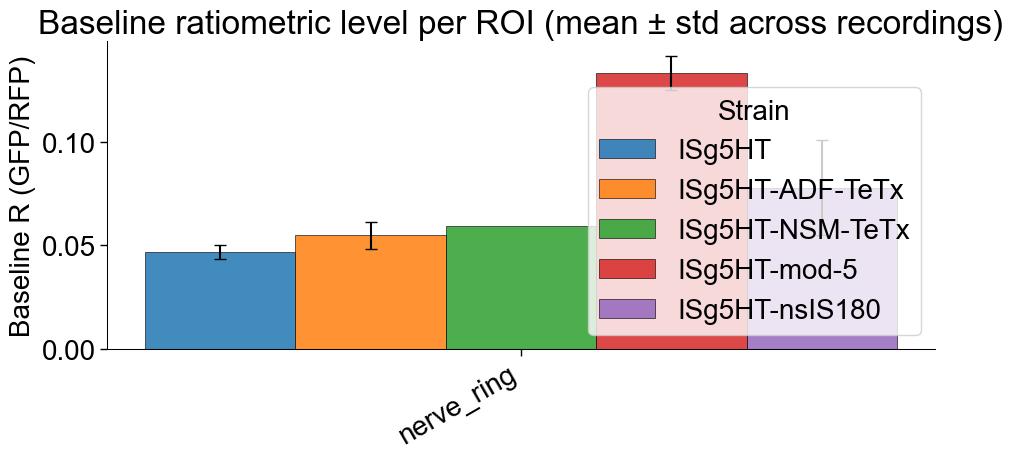

Plot 2: GFP vs RFP scatter


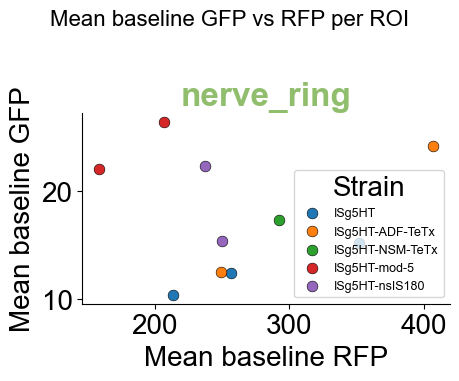

Plot 3: Per-channel (GFP, RFP) baseline levels


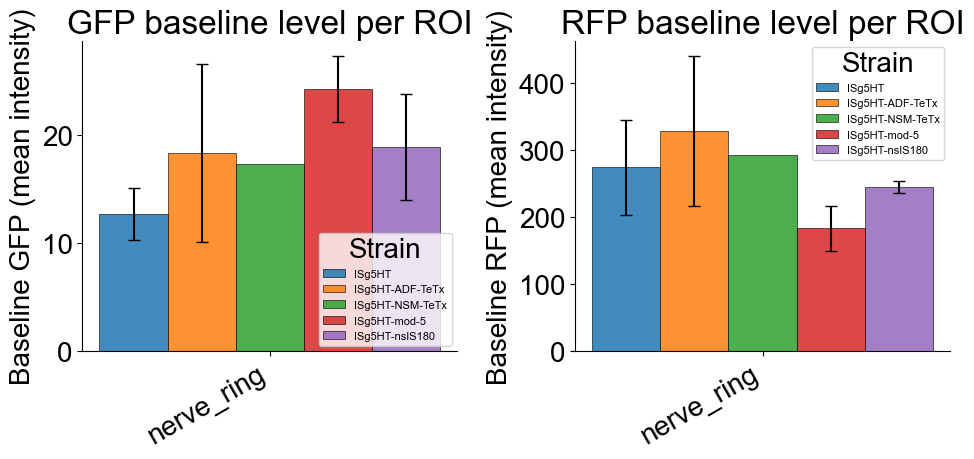

Plot 4: Coefficient of variation of baseline R


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


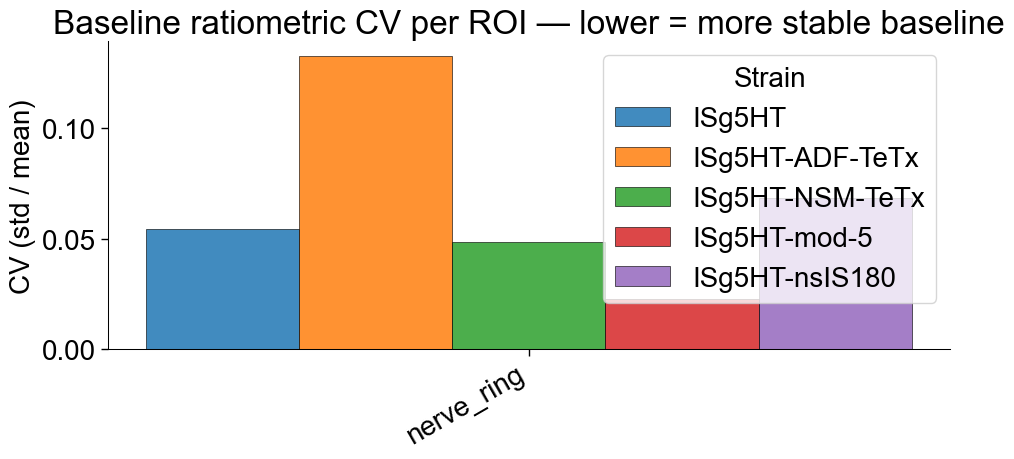

Plot 5: Per-frame baseline R distribution (strip plot)


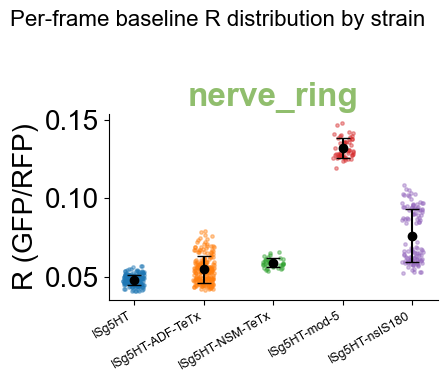

In [46]:
%matplotlib inline
import quantify_baseline
_ = importlib.reload(sys.modules['quantify_baseline'])
sys.argv = ["", r"D:\DATA\g5ht-free"]
quantify_baseline.main()

Scanning D:\DATA\g5ht-free for recordings with baselines …
Percentile = 95.0


  date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001: 60 baseline frames, strain=ISg5HT


  date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002: 120 baseline frames, strain=ISg5HT


  date-20251112_strain-ISg5HT_condition-fedpatch_worm002: 15 baseline frames, strain=ISg5HT


  date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003: 100 baseline frames, strain=ISg5HT-ADF-TeTx


  date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004: 100 baseline frames, strain=ISg5HT-ADF-TeTx


  date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004: 50 baseline frames, strain=ISg5HT-nsIS180


  date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005: 60 baseline frames, strain=ISg5HT-nsIS180


  date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm001: 30 baseline frames, strain=ISg5HT-mod-5


  date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003: 20 baseline frames, strain=ISg5HT-mod-5


  date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm008: 39 baseline frames, strain=ISg5HT-NSM-TeTx

Collected 10 recordings with defined baselines
Strains: ['ISg5HT', 'ISg5HT-ADF-TeTx', 'ISg5HT-NSM-TeTx', 'ISg5HT-mod-5', 'ISg5HT-nsIS180']

=== Percentile mode (P95) ===
Plot 1: Per-frame percentile distribution (strip)


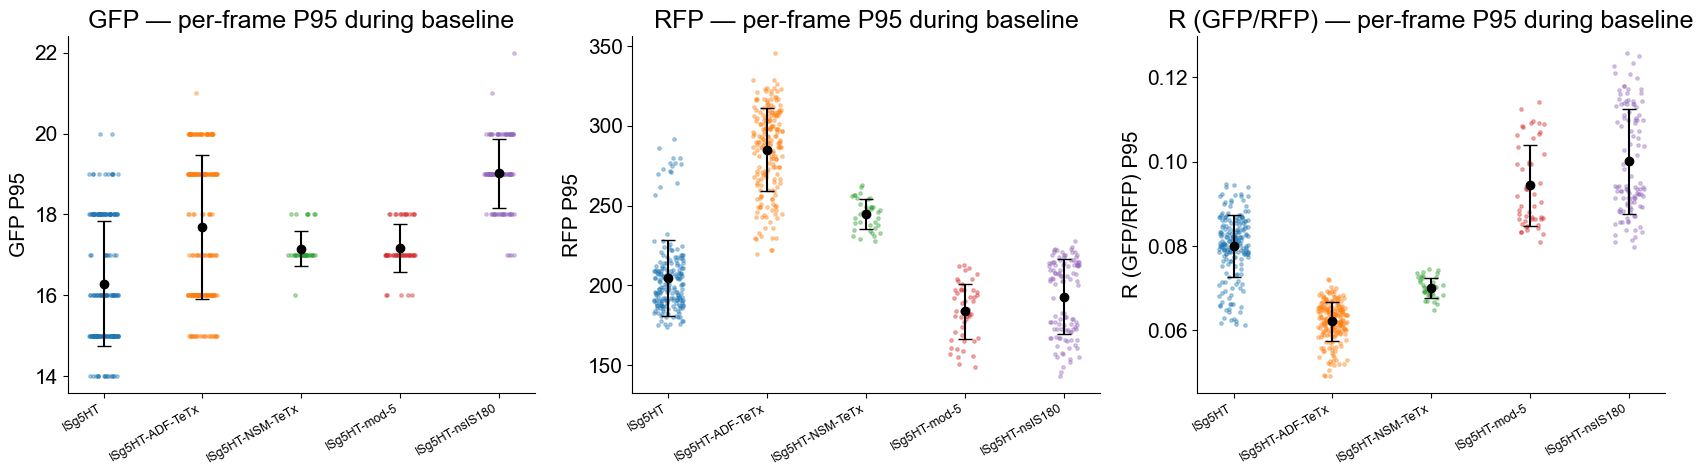

Plot 2: Session-mean percentile (bar)


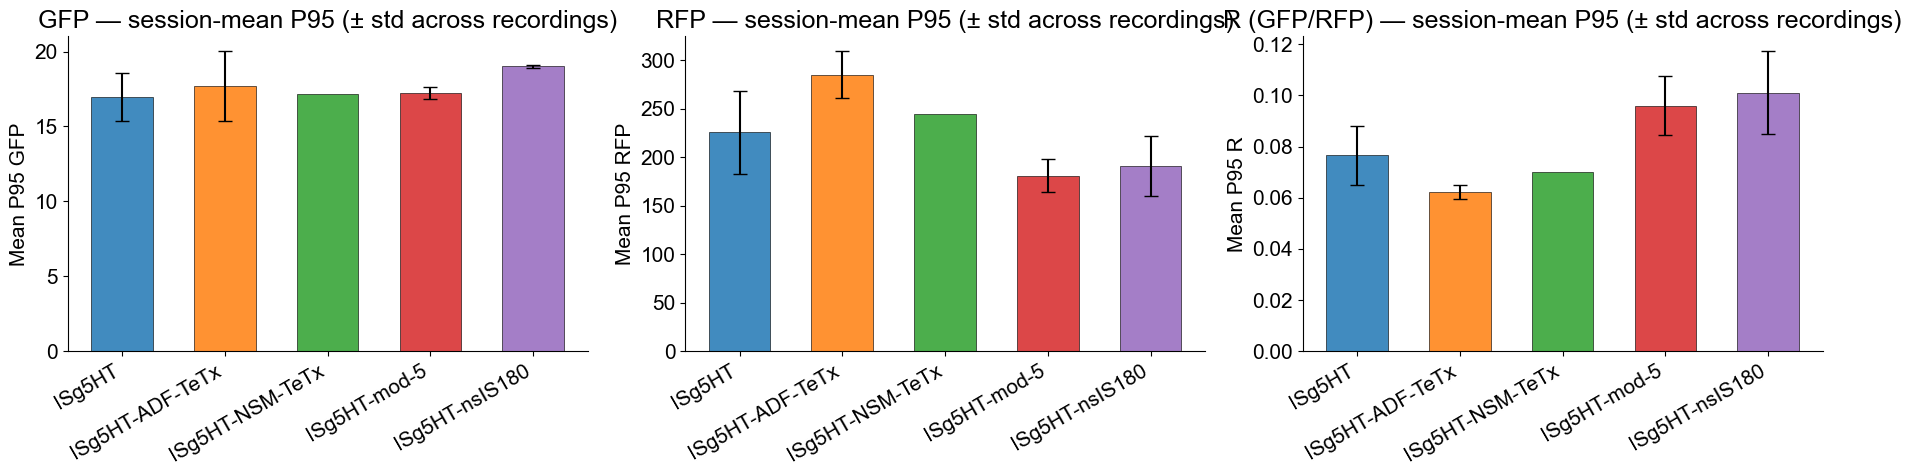

Plot 3: Percentile GFP vs RFP scatter


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


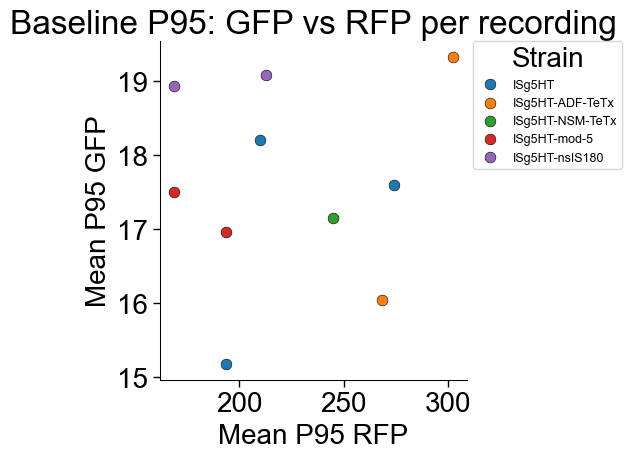


=== Whole-frame mean mode ===
Plot 4: Per-frame mean distribution (strip)


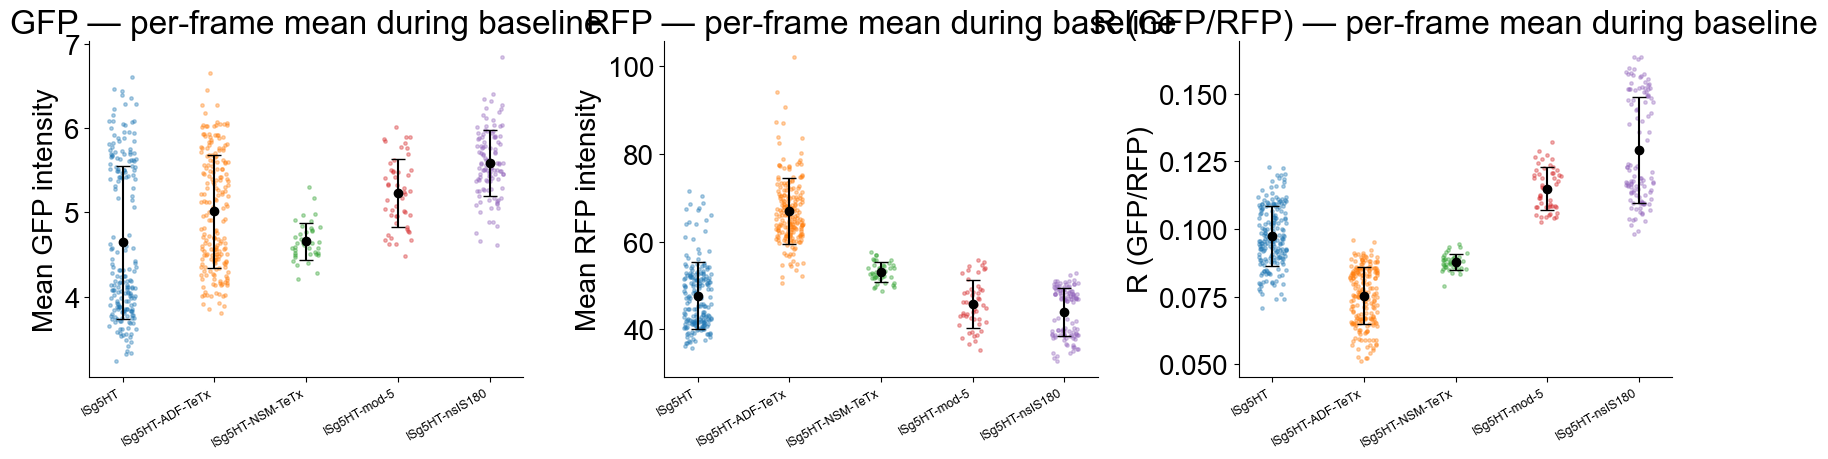

Plot 5: Session-mean intensity (bar)


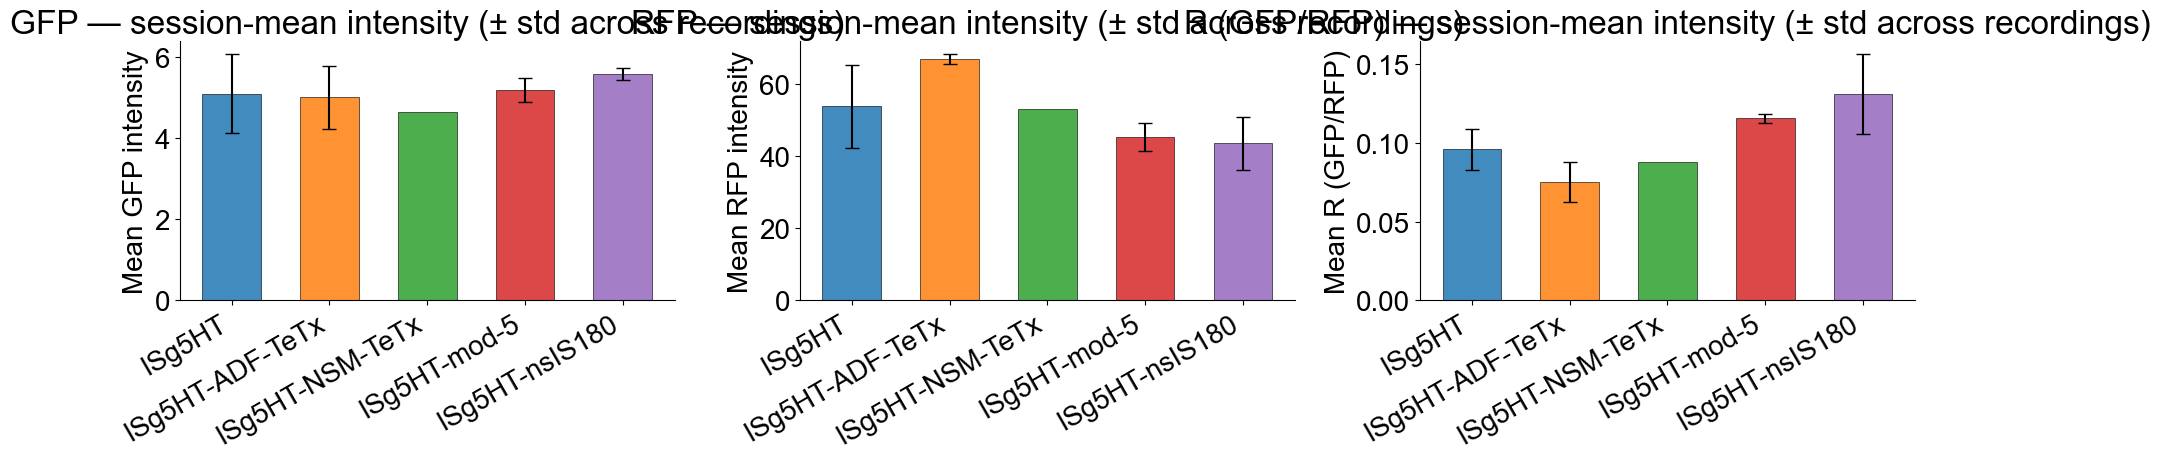

Plot 6: Mean GFP vs RFP scatter


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


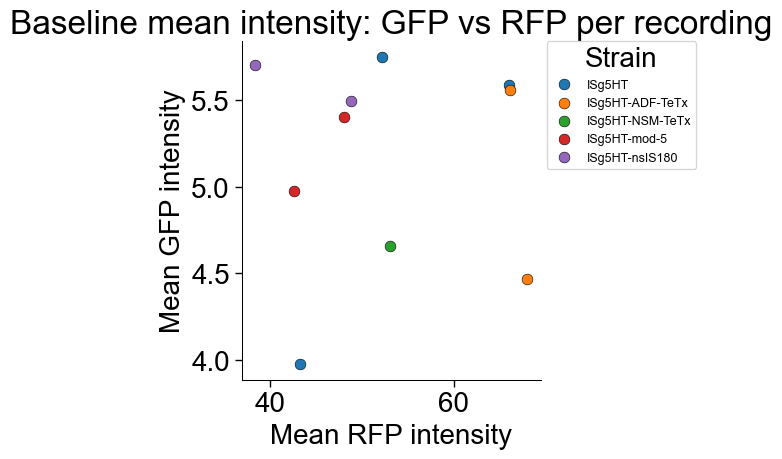

In [49]:
import quantify_baseline_frame_pct
_ = importlib.reload(sys.modules['quantify_baseline_frame_pct'])
sys.argv = ["", r"D:\DATA\g5ht-free", "95", "registered_elastix"]
quantify_baseline_frame_pct.main()

## 12 QUANTIFY VOXELS


saves ~12GB of data

takes around 15 minutes

In [4]:
import sys
import os
import quantify_voxels
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage.morphology import erosion, disk
import importlib
import glob

import matplotlib
%matplotlib widget
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

_ = importlib.reload(sys.modules['quantify_voxels'])

PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
reg_dir = 'registered_elastix'

sys.argv = ["", PTH, reg_dir]
quantify_voxels.main()

Loaded metadata from D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001\metadata.json
  fps=1.8762, nframes=1200, binning_factor=1
  baseline_window=(0, 60), encounter_frame=128
  bad_frames: 0 frames
Processing 1200 registered stacks …


Loading stacks: 100%|██████████| 1200/1200 [01:49<00:00, 10.93it/s]


Computed baseline mean over frames (0, 60)
Computed F20 (20th percentile across time)
Ratio array shape: (1200, 40, 200, 500)
Saving to D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_processed_voxels.h5 …
Done — saved D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_processed_voxels.h5


In [2]:
# quantify voxels for all recordings

import sys
import os
import quantify_voxels
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage.morphology import erosion, disk
import importlib
import glob

import matplotlib
%matplotlib widget
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

_ = importlib.reload(sys.modules['quantify_voxels'])


require_metadata = True

# loop over all recordings
DATA_PTH = r'D:\DATA\g5ht-free'
worm_tuple = ('worm001', 'worm002', 'worm003', 'worm004', 'worm005', 'worm006', 'worm007', 'worm008', 'worm009', 'worm010', 'worm011')

date_pths = [os.path.join(DATA_PTH, d) for d in os.listdir(DATA_PTH) if os.path.isdir(os.path.join(DATA_PTH, d))]

# in each folder in date_pths, look for folders that end with 'wormXXX', where XXX is a three digit number, and then look for the 'registered_elastix' folder inside that folder to create the mp4
for date_pth in date_pths:
    # print(date_pth)
    worm_pths = [os.path.join(date_pth, d) for d in os.listdir(date_pth) if os.path.isdir(os.path.join(date_pth, d)) and d.endswith(worm_tuple)]
    # print(worm_pths)
    for worm_pth in worm_pths:
        # check for an a *_processed_data.h5 in worm_pth
        processed_data_files = glob.glob(os.path.join(worm_pth, '*_processed_data.h5'))
        if len(processed_data_files) > 0:
            print(f"Found processed data file {processed_data_files[0]} in {worm_pth}, skipping quantification for this recording")
            continue
        
        reg_dir = 'registered_elastix'
        # check that reg_dir exists in worm_pth
        reg_dir_pth = os.path.join(worm_pth, reg_dir)
        elastix_exists = os.path.exists(os.path.join(reg_dir_pth))
        if not elastix_exists:
            print(f"Registered directory {reg_dir} not found in {worm_pth}, checking for wholistic registration directory")
            reg_dir  = 'registered_wholistic_smooth-0.200_patch-7'
            reg_dir_pth = os.path.join(worm_pth, reg_dir)
            elastix_exists = os.path.exists(os.path.join(reg_dir_pth))
            if not elastix_exists:
                print(f"Registered directory {reg_dir} not found in {worm_pth}, skipping quantification for this recording")
                continue
            else:
                print(f"Found wholistic registration directory {reg_dir} in {worm_pth}, using this for quantification")
        
        print(f"\nQuantifying voxels for {worm_pth} using registration directory {reg_dir} …\n")
        
        sys.argv = ["", worm_pth, reg_dir, require_metadata]
        quantify_voxels.main()
                


Quantifying voxels for D:\DATA\g5ht-free\022025_eft_41z_starved_worm002\022025_eft_41z_starved_worm002 using registration directory registered_elastix …

metadata.json not found in D:\DATA\g5ht-free\022025_eft_41z_starved_worm002\022025_eft_41z_starved_worm002 and require_metadata is True
Registered directory registered_elastix not found in D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005, checking for wholistic registration directory
Found wholistic registration directory registered_wholistic_smooth-0.200_patch-7 in D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005, using this for quantification

Quantifying voxels for D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005 using registration directory registered_wholistic_smooth-0.200_patch-7 …

Loaded metadata from D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\metadata.json
  fps=1.8762, nfr

Loading stacks: 100%|██████████| 1200/1200 [03:14<00:00,  6.18it/s]


NaN-filled 270 bad frames in ratio array
Computed baseline mean over frames (0, 100)
Computed F20 (20th percentile across time)
Ratio array shape: (1200, 39, 200, 500)
Saving to D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-fedpatch_worm001 using registration directory registered_elastix …

metadata.json not found in D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-fedpatch_worm001 and require_metadata is True

Quantifying voxels for D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004 using registration directory registered_elastix …

Loaded metadata from D:\D

Loading stacks: 100%|██████████| 1178/1178 [01:38<00:00, 11.95it/s]


NaN-filled 150 bad frames in ratio array
No baseline_window set — skipping baseline computation
Computed F20 (20th percentile across time)
Ratio array shape: (1178, 39, 200, 500)
Saving to D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005\metadata.json
  fps=1.8762, nframes=562, binning_factor=1
  baseline_window=(0, 60), encounter_frame=169
  bad_frames: 24 frames
Processing 562 registered stacks …


Loading stacks: 100%|██████████| 562/562 [00:52<00:00, 10.74it/s]


NaN-filled 24 bad frames in ratio array
Computed baseline mean over frames (0, 60)
Computed F20 (20th percentile across time)
Ratio array shape: (562, 39, 200, 500)
Saving to D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004\metadata.json
  fps=1.8762, nframes=1167, binning_factor=1
  baseline_window=(490, 540), encounter_frame=675
  bad_frames: 0 frames
Processing 1167 registered stacks …


Loading stacks: 100%|██████████| 1167/1167 [01:41<00:00, 11.46it/s]


Computed baseline mean over frames (490, 540)
Computed F20 (20th percentile across time)
Ratio array shape: (1167, 39, 200, 500)
Saving to D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001\metadata.json
  fps=1.8762, nframes=1200, binning_factor=1
  baseline_window=(0, 60), encounter_frame=128
  bad_frames: 0 frames
Processing 1200 registered stacks …


Loading stacks: 100%|██████████| 1200/1200 [02:06<00:00,  9.48it/s]


Computed baseline mean over frames (0, 60)
Computed F20 (20th percentile across time)
Ratio array shape: (1200, 40, 200, 500)
Saving to D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002\metadata.json
  fps=1.8762, nframes=607, binning_factor=1
  baseline_window=(0, 120), encounter_frame=335
  bad_frames: 7 frames
Processing 607 registered stacks …


Loading stacks: 100%|██████████| 607/607 [01:02<00:00,  9.64it/s]


NaN-filled 7 bad frames in ratio array
Computed baseline mean over frames (0, 120)
Computed F20 (20th percentile across time)
Ratio array shape: (607, 40, 200, 500)
Saving to D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20260220\date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm008 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20260220\date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm008\metadata.json
  fps=1.8762, nframes=1108, binning_factor=1
  baseline_window=(201, 240), encounter_frame=338
  bad_frames: 217 frames
Processing 1108 register

Loading stacks: 100%|██████████| 1108/1108 [01:35<00:00, 11.63it/s]


NaN-filled 217 bad frames in ratio array
Computed baseline mean over frames (201, 240)
Computed F20 (20th percentile across time)
Ratio array shape: (1108, 39, 200, 500)
Saving to D:\DATA\g5ht-free\20260220\date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm008\date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm008_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20260220\date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm008\date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm008_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003\metadata.json
  fps=1.8762, nframes=1091, binning_factor=1
  baseline_window=(0, 100), encounter_frame=265
  bad_frames: 22 frames
Processing 1091 registered

Loading stacks: 100%|██████████| 1091/1091 [01:47<00:00, 10.11it/s]


NaN-filled 22 bad frames in ratio array
Computed baseline mean over frames (0, 100)
Computed F20 (20th percentile across time)
Ratio array shape: (1091, 39, 200, 500)
Saving to D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004\metadata.json
  fps=1.8762, nframes=852, binning_factor=1
  baseline_window=(0, 100), encounter_frame=145
  bad_frames: 0 frames
Processing 852 registered stack

Loading stacks: 100%|██████████| 852/852 [01:07<00:00, 12.71it/s]


Computed baseline mean over frames (0, 100)
Computed F20 (20th percentile across time)
Ratio array shape: (852, 39, 200, 500)
Saving to D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm001 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm001\metadata.json
  fps=1.8762, nframes=1199, binning_factor=1
  baseline_window=(0, 30), encounter_frame=123
  bad_frames: 19 frames
Processing 1199 registered stacks …


Loading stacks: 100%|██████████| 1199/1199 [02:02<00:00,  9.79it/s]


NaN-filled 19 bad frames in ratio array
Computed baseline mean over frames (0, 30)
Computed F20 (20th percentile across time)
Ratio array shape: (1199, 39, 200, 500)
Saving to D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm001\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm001_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm001\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm001_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003\metadata.json
  fps=1.8762, nframes=464, binning_factor=1
  baseline_window=(0, 20), encounter_frame=65
  bad_frames: 14 frames
Processing 464 registered stacks …


Loading stacks: 100%|██████████| 464/464 [00:35<00:00, 12.94it/s]


NaN-filled 14 bad frames in ratio array
Computed baseline mean over frames (0, 20)
Computed F20 (20th percentile across time)
Ratio array shape: (464, 39, 200, 500)
Saving to D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20251112\date-20251112_strain-ISg5HT_condition-fedpatch_worm002 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20251112\date-20251112_strain-ISg5HT_condition-fedpatch_worm002\metadata.json
  fps=1.8762, nframes=1191, binning_factor=1
  baseline_window=(0, 15), encounter_frame=155
  bad_frames: 0 frames
Processing 1191 registered stacks …


Loading stacks: 100%|██████████| 1191/1191 [02:23<00:00,  8.30it/s]


Computed baseline mean over frames (0, 15)
Computed F20 (20th percentile across time)
Ratio array shape: (1191, 40, 200, 500)
Saving to D:\DATA\g5ht-free\20251112\date-20251112_strain-ISg5HT_condition-fedpatch_worm002\date-20251112_strain-ISg5HT_condition-fedpatch_worm002_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20251112\date-20251112_strain-ISg5HT_condition-fedpatch_worm002\date-20251112_strain-ISg5HT_condition-fedpatch_worm002_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20260217\date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003 using registration directory registered_elastix …

Loaded metadata from D:\DATA\g5ht-free\20260217\date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003\metadata.json
  fps=1.8762, nframes=1200, binning_factor=1
  baseline_window=None, encounter_frame=749
  bad_frames: 3 frames
Processing 1200 registered stacks …


Loading stacks: 100%|██████████| 1200/1200 [01:57<00:00, 10.18it/s]


NaN-filled 3 bad frames in ratio array
No baseline_window set — skipping baseline computation
Computed F20 (20th percentile across time)
Ratio array shape: (1200, 39, 200, 500)
Saving to D:\DATA\g5ht-free\20260217\date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003\date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003_processed_data.h5 …
Done — saved D:\DATA\g5ht-free\20260217\date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003\date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003_processed_data.h5

Quantifying voxels for D:\DATA\g5ht-free\20251107\date-20251107_strain-ISg5HT_condition-fedpatch_worm003 using registration directory registered_elastix …

metadata.json not found in D:\DATA\g5ht-free\20251107\date-20251107_strain-ISg5HT_condition-fedpatch_worm003 and require_metadata is True


# GRID ANALYSIS

In [1]:
import grid_analysis
import sys
import importlib
_ = importlib.reload(sys.modules['grid_analysis'])

PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

xspace = 20
yspace = 40
fps = 1/0.533
bin_factor = 1
z_start = 0
z_end = 39
baseline_start_sec = 5 # start baseline calculation here (relative to the start of the recording, not relative to start_time_sec)
baseline_end_sec = 35 # end baseline calculation here (relative to the start of the recording, not relative to start_time_sec)
start_time_sec = 0
time_food_sec = 70
sys.argv = ["", PTH, xspace, yspace, fps, bin_factor, z_start, z_end, baseline_start_sec, baseline_end_sec, start_time_sec]#time_food_sec] 
grid_analysis.main()

Input directory: D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001
Grid spacing: (20, 40)
FPS: 1.8761726078799248
Binning factor: 1
Z slice range: 0 to 39
Baseline window: 5.0 to 35.0 sec
Start time: 0.0 sec
Food time: None sec


FileNotFoundError: Normalized voxels not found at D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001\normalized_voxels.npy

In [ ]:
import grid_analysis
_ = importlib.reload(sys.modules['grid_analysis'])
# load the grid_timeseries_flat_smoothed.npz file and plot the heatmap using the plot_heatmap function
data = np.load(os.path.join(PTH, 'grid_timeseries_flat_smoothed.npz'))
flat_timeseries_smoothed = data['timeseries']
z_labels = data['z_labels']
grid_analysis.plot_heatmap(flat_timeseries_smoothed, z_labels, fps=1/0.533, output_path=os.path.join(PTH, 'grid_heatmap.png'), data_start_time=start_time_sec)
# grid_analysis.plot_heatmap(flat_timeseries_smoothed, z_labels, fps=1/0.533, output_path=os.path.join(PTH, 'grid_heatmap.png'), data_start_time=start_time_sec)

In [ ]:
flat_timeseries_smoothed.shape

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(flat_timeseries_smoothed.shape[0])/fps,flat_timeseries_smoothed[:,20:27])
# plt.ylim(0.03,0.3)
plt.show()

In [ ]:
np.unique(z_labels)

In [ ]:
flat_timeseries_smoothed.shape

In [ ]:
_ = importlib.reload(sys.modules['grid_analysis'])
# sort the grid squares by their mean signal across time, and plot the heatmap again with the grid squares in sorted order
mean_signal_grid = flat_timeseries_smoothed.mean(axis=0)
sorted_indices = np.argsort(mean_signal_grid)
flat_timeseries_smoothed_sorted = flat_timeseries_smoothed[:, sorted_indices]

plt.close('all')

# smooth some more
from grid_analysis import causal_smooth
toplot = causal_smooth(flat_timeseries_smoothed_sorted, sigma=1.0)
grid_analysis.plot_heatmap(toplot, z_labels, fps=1/0.533, output_path=os.path.join(PTH, 'grid_heatmap_sorted.png'), data_start_time=start_time_sec)
# plt.xlim(-50,125)
# plt.ylim(50,770)

# plot the mean signal across all grid squares for each z-slice over time, and mark the time of food addition
mean_signal_grid = flat_timeseries_smoothed.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(flat_timeseries_smoothed.shape[0])/fps - start_time_sec, mean_signal_grid)
plt.axvline(0, color='red', linestyle='--', label='Food addition')
plt.xlabel('Time (sec)')
plt.ylabel('Mean $F/F_{\\mathrm{baseline}}$ across grid squares')
plt.legend()
# plt.xlim(-50,125)
# plt.ylim(0.03,0.3)
plt.show()

In [ ]:
flat_timeseries_smoothed.shape

In [ ]:
# pca on flat_timeseries_smoothed, which of size (time,features)
from sklearn.decomposition import PCA
import utils
pca = PCA(n_components=5)
pca.fit(flat_timeseries_smoothed)
# get scores
pc_scores = pca.transform(flat_timeseries_smoothed)
explained_variance = pca.explained_variance_ratio_
explained_variance


line_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
ylim = (-12,14)
for i in range(5):
    fig, ax = utils.pretty_plot()
    ax.plot(np.arange(pc_scores.shape[0])/fps, pc_scores[:,i], label=f'PC{i+1}', lw=3, color=line_colors[i])
    ax.set_ylim(ylim)
    ax.set_xlabel('Time (sec)')
    plt.ylabel(f'PC{i+1} projection')
    plt.show()

# scree plot
fig, ax = utils.pretty_plot()
ax.bar(np.arange(len(explained_variance))+1, explained_variance*100)
ax.set_xlabel('PC')
ax.set_ylabel('Variance explained (%)')
plt.show()

In [ ]:
# cluster flat_timeseries_smoothed, then plot heatmap with clusters indicated
from sklearn.cluster import KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(flat_timeseries_smoothed.T)
cluster_labels = kmeans.labels_


In [ ]:
plt.figure()
plt.plot(sorted_timeseries)
plt.show()

In [ ]:
# sort flat_timeseries_smoothed by cluster labels
sorted_indices = np.argsort(cluster_labels)
sorted_timeseries = flat_timeseries_smoothed[:, sorted_indices]

plt, ax = utils.pretty_plot(figsize=(10,6))
im = ax.pcolormesh(sorted_timeseries.T, cmap='plasma')
plt.show()

# plot mean of each cluster over time on the same axis
i = 0
for c in range(n_clusters-1):
    cluster_mean = flat_timeseries_smoothed[:, cluster_labels == c].mean(axis=1)
    # normalize between 0 and 1
    cluster_mean = (cluster_mean - cluster_mean.min()) / (cluster_mean.max() - cluster_mean.min())
    # smooth cluste means
    # cluster_mean = pca_analysis.causal_smooth(cluster_mean[:,np.newaxis], sigma=3.0)
    if i==0:
        fig, ax = utils.pretty_plot()
    ax.plot(np.arange(cluster_mean.shape[0])/fps, cluster_mean, lw=1)
    ax.set_xlabel('Time (sec)')
    # plt.ylabel(f'Cluster {c+1} mean $F/F_{{\\mathrm{{baseline}}}}$')
    i += 1
plt.show()

# cross correlation between cluster 1 and 2 means signals
from scipy.signal import correlate
cluster1_mean = flat_timeseries_smoothed[:, cluster_labels == 0].mean(axis=1)
cluster2_mean = flat_timeseries_smoothed[:, cluster_labels == 1].mean(axis=1)
# normalize means bwetween 0 and 1
cluster1_mean = (cluster1_mean - cluster1_mean.min()) / (cluster1_mean.max() - cluster1_mean.min())
cluster2_mean = (cluster2_mean - cluster2_mean.min()) / (cluster2_mean.max() - cluster2_mean.min())
# compute cross-correlation
corr = correlate(cluster1_mean - cluster1_mean.mean(), cluster2_mean - cluster2_mean.mean(), mode='full')
lags = np.arange(-len(cluster1_mean)+1, len(cluster1_mean))
# plot xcorr
fig, ax = utils.pretty_plot()
ax.plot(lags/fps, corr)
ax.set_xlabel('Lag (sec)')
ax.set_ylabel('Cross-correlation')
plt.show()

# PCA analysis

In [ ]:
import pca_analysis
import sys
_ = importlib.reload(sys.modules['pca_analysis'])

PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

# Arguments: input_dir, fps, bin_factor, z_start, z_end, lowpass_freq, n_components,
#            n_pcs_plot, baseline_start, baseline_end, start_time, time_offset
sys.argv = ["", PTH, 1/0.533, 1, 7, 18, 0, 50, 6, 5, 35, 0]
pca_analysis.main()

# DMD analysis

In [ ]:
import dmd_analysis
import sys
_ = importlib.reload(sys.modules['dmd_analysis'])

PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

# Arguments: input_dir, fps, bin_factor, z_start, z_end, lowpass_freq, dmd_rank, 
#            n_modes_plot, baseline_start, baseline_end, start_time, time_offset
sys.argv = ["", PTH, 1/0.533, 1, 7, 18, 0, 5, 6, 5, 35, 0]

dmd_analysis.main()

# DIFFUSION MODELING

- 20251223 worm005
- choose a z slice (z=26)
- choose frames (800-1000)
- make movie
- show gfp/rfp frame for 822

- load 2x2 binned, R/R0 
- load mask and bin

## Conceptual Explanation of the Reaction-Diffusion Model

### The Physical Picture

Imagine you're watching serotonin (or another signaling molecule) being released, spreading, and getting taken back up in a worm's nervous system. The fluorescence intensity you measure at each pixel reflects this dynamic process. The code models three key phenomena:

1. **Diffusion**: Molecules spread from high to low concentration regions, like ink dropped in water
2. **Decay/Reuptake**: Molecules are removed from the extracellular space (via transporters, degradation, etc.) at a rate proportional to their local concentration
3. **Release Sources**: Certain locations periodically release molecules into the system

### The Mathematical Model

The fluorescence field $i(x,y,t)$ evolves according to a **reaction-diffusion PDE**:

$$\frac{\partial i}{\partial t} = D \nabla^2 i - k \cdot i + s(x,y,t)$$

Where:
- $D$ is the **diffusion coefficient** (how fast molecules spread spatially)
- $k$ is the **decay rate** (how fast molecules are removed)
- $s(x,y,t)$ is the **source field** (where and when molecules are released)

### Discretization on an Irregular Domain

Since you have a tissue mask (not a regular rectangle), the code builds a **graph Laplacian**. Each masked pixel becomes a node, connected to its 4 neighbors. The Laplacian operator $L$ is a sparse matrix where:
- Off-diagonal entries are +1 for connected pixels
- Diagonal entries are −(number of neighbors)

This naturally implements **no-flux boundary conditions**: at the mask edge, there are simply fewer neighbors, so diffusion stops there automatically.

### Time Stepping (Semi-Implicit)

To advance the simulation forward in time, the code uses a **backward Euler** (or optionally Crank-Nicolson) scheme. Instead of naively computing "next = current + dt × derivative" (which can blow up), it solves:

$$(I - dt \cdot A) \cdot i_{t+1} = i_t + dt \cdot s_t$$

where $A = D \cdot L - k \cdot I$. This requires solving a linear system at each time step, but the matrix is **sparse** and gets **LU-factorized once**, making subsequent solves very fast.

### Learning the Source Field from Data

The source term $s(x,y,t)$ is unknown. The code learns it from the movie itself using **Non-negative Matrix Factorization (NMF)**:

1. **Preprocessing**: High-pass filter the movie temporally (remove slow baseline drift), then rectify (keep only positive values, since we're interested in "release-like" transient increases)

2. **NMF Decomposition**: Factor the preprocessed activity as:
   $$A \approx W \cdot H$$
   where $W$ is (time × M) and $H$ is (M × pixels). This finds M spatial patterns that, when weighted by time-varying amplitudes, reconstruct the activity.

3. **Interpretation**: 
   - $\Phi = H^T$ (N×M) are the **spatial source maps** — where release happens
   - $a_t = W$ (T×M) are the **time courses** — when each source is active

The source field is then: $s(t) = g \cdot \Phi \cdot a_t$, where $g$ is a global gain parameter.

### The Fitting Pipeline

The full fitting process is **staged**:

1. **Learn sources** (Φ, a_t) via NMF on the preprocessed movie — this identifies *where* and *when* release happens

2. **Fit parameters** (D, k, g) with sources fixed — the optimizer simulates the model with candidate parameters and minimizes the mismatch to observed data

3. **Optionally refine** the time courses with temporal smoothness regularization

### Parameter Fitting Details

The optimizer (L-BFGS-B) searches for D, k, g that minimize mean squared error between simulated and observed fluorescence. To enforce positivity, parameters are represented in log-space: optimizing $\log(D)$ ensures $D > 0$.

For efficiency with large images:
- The Laplacian is **sparse** (only ~4N nonzero entries for N pixels)
- The implicit matrix is **factorized once** per (D,k) pair
- Loss is computed on a **random subset** of pixels

### What the Results Tell You

- **D (pixels²/s)**: How fast the signal spreads spatially. Larger D means faster diffusion. Remember to scale by pixel size² if comparing across binning levels.
  - If your original pixel size is s (µm/pixel), and you bin by factor b, then fitted Dbinned​ relates to physical Dμm roughly by:
    - Dμm2/s≈Dbinned⋅(b s)^2

- **k (1/s)**: How fast the signal decays. The "half-life" is $\ln(2)/k$ seconds.

- **Φ (spatial maps)**: Where the sources are located. Each column is a probability-like distribution over pixels.

- **a_t (time courses)**: When each source is active. Peaks indicate release events.

- **R²**: Overall fit quality — how much variance the model explains.

### Key Design Choices

1. **Phenomenological, not biophysical**: The model fits the *fluorescence* dynamics directly, not the underlying concentration. This avoids needing to know the sensor's binding kinetics.

2. **Data-driven sources**: Rather than assuming source locations, NMF discovers them from the data's spatio-temporal structure.

3. **Implicit time stepping**: Ensures numerical stability even with large D or dt.

4. **Modular pipeline**: Each stage can be tuned independently (e.g., adjust NMF preprocessing, change number of sources, use Crank-Nicolson for better accuracy).

### REGULARIZATION

1. **L1 sparsity on source time courses** - encourages bursts rather than continuous activity
2. **Total Variation (TV) on sources** - penalizes frequent changes, promoting sparse "events"  
3. **D prior/regularization** - soft prior pushing D away from zero
4. **Source energy penalty** - limits total source "power" to force more diffusion 


## Regularization Added to diffusion_v2.py

I've added optional regularization to prevent D from collapsing to near-zero. The key additions:

### `RegularizationConfig` dataclass
Located around line 900, this controls all regularization terms:

```python
reg_config = RegularizationConfig(
    # Source sparsity (temporal)
    source_l1_weight=0.1,    # L1 penalty: ∑|a_t| — promotes sparse firing
    source_tv_weight=0.05,   # TV penalty: ∑|a_t - a_{t-1}| — promotes discrete events
    source_energy_weight=0.0, # L2 penalty: ∑a_t² — limits total source power
    
    # D priors (prevent collapse)
    D_min_penalty_weight=0.001,  # 1/D penalty — blows up as D→0
    D_prior_weight=0.5,          # Gaussian prior on log(D)
    D_prior_mean=0.05,           # Prior mean for D
    
    # Source gain limit
    g_max_penalty_weight=0.0,    # Penalty if g exceeds threshold
    g_max_threshold=5.0          # Threshold for g penalty
)
```

### How It Works

The regularized loss is:

$$
\mathcal{L}_{\text{reg}} = \mathcal{L}_{\text{data}} + \lambda_1 \|a_t\|_1 + \lambda_{TV} \text{TV}(a_t) + \frac{\alpha}{D} + \beta (\log D - \log D_0)^2
$$

| Term | Effect |
|------|--------|
| `source_l1_weight` | Forces sources to be sparse in time (few frames active) |
| `source_tv_weight` | Forces sources to have discrete on/off events |
| `D_min_penalty_weight` | $\frac{1}{D}$ penalty prevents D→0 |
| `D_prior_weight` | Soft prior pulling D toward `D_prior_mean` |

### Usage

```python
from diffusion_v2 import RegularizationConfig, fit_diffusion_model_2d

reg_config = RegularizationConfig(
    source_l1_weight=0.1,
    D_prior_weight=0.5,
    D_prior_mean=0.05  # Your expected D value
)

result = fit_diffusion_model_2d(
    Y, mask, dt,
    reg_config=reg_config,  # Pass the config
    ...
)
```

### Tuning Tips

1. **If D still collapses**: Increase `D_min_penalty_weight` or `D_prior_weight`
2. **If sources are too active**: Increase `source_l1_weight` 
3. **If sources are noisy/oscillatory**: Increase `source_tv_weight`
4. **Set `D_prior_mean`** to your expected diffusion coefficient from physics/calibration

Made changes.



## SAVE TRIMMED DATA

In [ ]:
import sys
import os
import quantify_voxels
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage.morphology import erosion, disk
import importlib
import glob

import matplotlib
%matplotlib widget
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

_ = importlib.reload(sys.modules['quantify_voxels'])

PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'
bin_factor = 2
fps = 1/0.533
frames = (800,1000)  # only analyze frames from 800 to 1000
z = 26
zero_prob_threshold = 0.3 # remove voxels that are zero more than this fraction of the time


# load normalized_voxels.npy (R/R0), already been binned by bin_factor
g5 = np.load(os.path.join(PTH, 'normalized_voxels.npy'))
# load mask, bin it
fixed_mask_fn = glob.glob(os.path.join(PTH, 'fixed_mask_*.tif'))[0]
mask = tifffile.imread(fixed_mask_fn)
h, w = mask.shape
h_binned = h // bin_factor
w_binned = w // bin_factor
mask_binned = mask.reshape(h_binned, bin_factor, w_binned, bin_factor).max(axis=(1,3))
# mask g5 data
g5_trimmed = g5[frames[0]:frames[1], z, :, :]

# remove voxels that are only present a small percentage of the time
# find percentage of time a voxel is zero within the worm mask
g5_masked = g5 * mask_binned[np.newaxis, :, :]

# g5_masked is shape (T, Z, H, W) array with zeros outside the worm region
# find all voxels where g5_masked is zero for each time point
zero_mask = g5_masked == 0
# calculate the probability of a voxel being zero across time, but don't include time points where the voxel is masked out (i.e., outside the worm)
zero_prob = np.mean(zero_mask, axis=0)
# set zero probability to NaN for voxels outside the worm (mask binned needs a z dimension added)
zero_prob[mask_binned[np.newaxis].repeat(zero_prob.shape[0], axis=0) == 0] = np.nan
good_voxel_mask = zero_prob < zero_prob_threshold
g5 = g5_masked * good_voxel_mask[np.newaxis].repeat(g5_masked.shape[0], axis=0)

# save g5_trimmed and mask_binned to a npy file
np.savez(os.path.join(PTH, f'g5_trimmed_frames{frames[0]}to{frames[1]}.npz'), g5=g5, mask_binned=mask_binned, zero_prob=zero_prob)


## LOAD DATA

In [ ]:
import sys
import os
import quantify_voxels
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage.morphology import erosion, disk
import importlib
import glob

import matplotlib
%matplotlib widget
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

_ = importlib.reload(sys.modules['quantify_voxels'])

PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'
bin_factor = 2
fps = 1/0.533
# frames = (800,1000)  # only analyze frames from 800 to 1000 (these time points correspond to start of food encounter and two serotonin cycles)
frames = (800,1199)
z = 26
rfp_thresh = 50 # only include voxels where rfp_mean is above this threshold
keep_width = (25,228) # only keep this x range before

# load g5_trimmed
data = np.load(os.path.join(PTH, f'g5_trimmed_frames.npz'))
g5 = data['g5'][frames[0]:frames[1], z, :, :]  # g5 is R/R0 for frames 800 to 1000
mask = data['mask_binned']
print(g5.shape)
print(mask.shape)

# load rfp_mean.npy
rfp_mean = np.load(os.path.join(PTH, 'rfp_mean.npy'))
print(rfp_mean.shape)
rfp_mean_z = rfp_mean[z,:,:] # HW

# update mask based on rfp_thresh
mask_updated = mask.copy()
mask_updated[rfp_mean_z < rfp_thresh] = 0

# g5 is R/R0 for a single z slice, for frames 800 to 1000
# mask_updated is the segmentation mask updated based on rfp_thresh
g5 = g5 * mask_updated[np.newaxis, :, :]

# trim width in g5 and mask_updated
g5 = g5[:, :, keep_width[0]:keep_width[1]]
mask_updated = mask_updated[:, keep_width[0]:keep_width[1]]
print('Number of voxels in updated mask:', np.sum(mask_updated > 0))

raise NotImplementedError('Need to implement temporal smoothing before moving on.')


In [ ]:
%matplotlib qt
plt.figure()
plt.hist(rfp_mean[z,:,:].ravel(), bins=100)
plt.show()

## TEST POINT SOURCE IDENTIFICATION

Identify candidate source voxels for point source diffusion model.

In [ ]:
def identify_point_sources(Y, mask, fps=1/0.533, n_sources=10, 
                          methods=['variance', 'early_response', 'peak_detection', 'gradient'],
                          early_window=(10, 60), baseline_window=(0, 60),
                          spatial_exclusion_radius=5, verbose=True):
    """
    Identify candidate point source locations from fluorescence movie.
    
    Parameters
    ----------
    Y : (T, H, W) array
        Fluorescence movie (already F/F0 or R/R0).
    mask : (H, W) bool array
        Tissue mask.
    fps : float
        Frames per second.
    n_sources : int
        Number of candidate sources to identify per method.
    methods : list of str
        Which detection methods to use. Options:
        - 'variance': High temporal variance voxels
        - 'early_response': Voxels that respond early
        - 'peak_detection': Voxels with strong transient peaks
        - 'gradient': Spatial gradient maxima (likely centers of activity)
    early_window : tuple (start_frame, end_frame)
        Time window to detect early responders.
    baseline_window : tuple (start_frame, end_frame)
        Baseline period for computing response magnitude.
    spatial_exclusion_radius : int
        Minimum distance (pixels) between detected sources.
    verbose : bool
        Print diagnostic info.
    
    Returns
    -------
    sources_dict : dict
        Dictionary with keys as method names, values as (M, 2) arrays of (row, col) coords.
    metrics_dict : dict
        Dictionary with metric values for each detected source.
    """
    T, H, W = Y.shape
    mask = mask.astype(bool)
    
    # Mask the data
    Y_masked = Y * mask[np.newaxis, :, :]
    
    sources_dict = {}
    metrics_dict = {}
    
    # =========================================================================
    # METHOD 1: TEMPORAL VARIANCE
    # =========================================================================
    if 'variance' in methods:
        # Compute temporal variance for each voxel (only where mask is True)
        var_map = np.var(Y_masked, axis=0)
        var_map[~mask] = 0  # Zero out outside mask
        
        # Find top n_sources local maxima
        sources_var = _find_local_maxima_2d(var_map, n_sources, 
                                            exclusion_radius=spatial_exclusion_radius,
                                            mask=mask)
        sources_dict['variance'] = sources_var
        metrics_dict['variance'] = var_map[sources_var[:, 0], sources_var[:, 1]]
        
        if verbose:
            print(f"Variance method: found {len(sources_var)} sources")
            print(f"  Variance range: {metrics_dict['variance'].min():.3f} - {metrics_dict['variance'].max():.3f}")
    
    # =========================================================================
    # METHOD 2: EARLY RESPONDERS
    # =========================================================================
    if 'early_response' in methods:
        # Compute baseline
        baseline = np.mean(Y_masked[baseline_window[0]:baseline_window[1]], axis=0)
        baseline[baseline == 0] = 1  # Avoid division by zero
        
        # Compute response magnitude in early window
        early_mean = np.mean(Y_masked[early_window[0]:early_window[1]], axis=0)
        response_mag = (early_mean - baseline) / baseline
        response_mag[~mask] = -np.inf  # Exclude outside mask
        
        # Find voxels with strongest early response
        sources_early = _find_local_maxima_2d(response_mag, n_sources,
                                              exclusion_radius=spatial_exclusion_radius,
                                              mask=mask)
        sources_dict['early_response'] = sources_early
        metrics_dict['early_response'] = response_mag[sources_early[:, 0], sources_early[:, 1]]
        
        if verbose:
            print(f"Early response method: found {len(sources_early)} sources")
            print(f"  Response magnitude range: {metrics_dict['early_response'].min():.3f} - {metrics_dict['early_response'].max():.3f}")
    
    # =========================================================================
    # METHOD 3: PEAK DETECTION (transient activity)
    # =========================================================================
    if 'peak_detection' in methods:
        from scipy.signal import find_peaks
        
        # For each voxel, count number of significant peaks
        peak_count_map = np.zeros((H, W))
        peak_height_map = np.zeros((H, W))
        
        for i in range(H):
            for j in range(W):
                if not mask[i, j]:
                    continue
                trace = Y_masked[:, i, j]
                # Find peaks with minimum prominence
                peaks, properties = find_peaks(trace, prominence=0.3, distance=10)
                peak_count_map[i, j] = len(peaks)
                if len(peaks) > 0:
                    peak_height_map[i, j] = np.max(properties['prominences'])
        
        # Use peak height as metric
        peak_height_map[~mask] = 0
        sources_peak = _find_local_maxima_2d(peak_height_map, n_sources,
                                             exclusion_radius=spatial_exclusion_radius,
                                             mask=mask)
        sources_dict['peak_detection'] = sources_peak
        metrics_dict['peak_detection'] = peak_height_map[sources_peak[:, 0], sources_peak[:, 1]]
        
        if verbose:
            print(f"Peak detection method: found {len(sources_peak)} sources")
            print(f"  Peak height range: {metrics_dict['peak_detection'].min():.3f} - {metrics_dict['peak_detection'].max():.3f}")
    
    # =========================================================================
    # METHOD 4: SPATIAL GRADIENT (centers of activity)
    # =========================================================================
    if 'gradient' in methods:
        # Compute mean intensity over time
        mean_intensity = np.mean(Y_masked, axis=0)
        
        # Compute Laplacian (regions where intensity is locally maximal)
        from scipy.ndimage import laplace
        laplacian = -laplace(mean_intensity)  # Negative because we want local maxima
        laplacian[~mask] = -np.inf
        
        sources_grad = _find_local_maxima_2d(laplacian, n_sources,
                                             exclusion_radius=spatial_exclusion_radius,
                                             mask=mask)
        sources_dict['gradient'] = sources_grad
        metrics_dict['gradient'] = laplacian[sources_grad[:, 0], sources_grad[:, 1]]
        
        if verbose:
            print(f"Gradient method: found {len(sources_grad)} sources")
            print(f"  Laplacian range: {metrics_dict['gradient'].min():.3f} - {metrics_dict['gradient'].max():.3f}")
    
    return sources_dict, metrics_dict


def _find_local_maxima_2d(metric_map, n_sources, exclusion_radius=5, mask=None):
    """
    Find n_sources local maxima in metric_map with spatial exclusion.
    
    Returns (n, 2) array of (row, col) coordinates.
    """
    from scipy.ndimage import maximum_filter
    
    if mask is not None:
        metric_map = metric_map.copy()
        metric_map[~mask] = -np.inf
    
    # Find local maxima using maximum filter
    local_max = maximum_filter(metric_map, size=exclusion_radius) == metric_map
    local_max[metric_map == -np.inf] = False
    local_max[np.isnan(metric_map)] = False
    
    # Get coordinates and values
    coords = np.argwhere(local_max)
    values = metric_map[local_max]
    
    # Sort by value (descending)
    sorted_idx = np.argsort(values)[::-1]
    coords_sorted = coords[sorted_idx]
    
    # Take top n_sources
    return coords_sorted[:n_sources]


def visualize_point_sources(Y, mask, sources_dict, metrics_dict, 
                            time_point=0, figsize=(18, 12)):
    """
    Visualize identified point sources overlaid on the image.
    
    Parameters
    ----------
    Y : (T, H, W) array
    mask : (H, W) bool
    sources_dict : dict
        Output from identify_point_sources.
    metrics_dict : dict
        Metrics from identify_point_sources.
    time_point : int
        Which time frame to show.
    figsize : tuple
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    
    n_methods = len(sources_dict)
    
    fig, axes = plt.subplots(2, n_methods, figsize=figsize, constrained_layout=True)
    if n_methods == 1:
        axes = axes.reshape(2, 1)
    
    # Row 1: Sources overlaid on single time frame
    # Row 2: Sources overlaid on temporal mean
    
    mean_img = np.mean(Y, axis=0)
    frame_img = Y[time_point]
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for col_idx, (method, sources) in enumerate(sources_dict.items()):
        # Top row: single frame
        ax1 = axes[0, col_idx]
        ax1.imshow(frame_img, cmap='gray', vmin=0, vmax=np.percentile(frame_img[mask], 99))
        
        for i, (row, col) in enumerate(sources):
            circle = Circle((col, row), radius=3, color=colors[i % 10], 
                          fill=False, linewidth=2, label=f'S{i+1}')
            ax1.add_patch(circle)
            ax1.plot(col, row, 'x', color=colors[i % 10], markersize=8, markeredgewidth=2)
        
        ax1.set_title(f'{method.replace("_", " ").title()}\n(Frame {time_point})')
        ax1.axis('off')
        
        # Bottom row: temporal mean
        ax2 = axes[1, col_idx]
        ax2.imshow(mean_img, cmap='gray', vmin=0, vmax=np.percentile(mean_img[mask], 99))
        
        for i, (row, col) in enumerate(sources):
            circle = Circle((col, row), radius=3, color=colors[i % 10], 
                          fill=False, linewidth=2)
            ax2.add_patch(circle)
            ax2.plot(col, row, 'x', color=colors[i % 10], markersize=8, markeredgewidth=2)
        
        ax2.set_title('Temporal Mean')
        ax2.axis('off')
    
    plt.suptitle('Identified Point Source Candidates', fontsize=16, y=0.98)
    plt.show()
    
    # Also plot the time traces for each source
    fig2, axes2 = plt.subplots(n_methods, 1, figsize=(12, 3*n_methods), constrained_layout=True)
    if n_methods == 1:
        axes2 = [axes2]
    
    t = np.arange(Y.shape[0]) / (1/0.533)  # Assume default fps
    
    for ax_idx, (method, sources) in enumerate(sources_dict.items()):
        ax = axes2[ax_idx]
        
        for i, (row, col) in enumerate(sources):
            trace = Y[:, row, col]
            ax.plot(t, trace, label=f'S{i+1} ({row},{col})', alpha=0.7, linewidth=1.5)
        
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('R/R₀')
        ax.set_title(f'{method.replace("_", " ").title()} - Source Time Traces')
        ax.legend(ncol=3, fontsize=8, frameon=False)
        ax.grid(alpha=0.3)
    
    plt.show()
    
    # Print metric values
    print("\n" + "="*60)
    print("SOURCE METRICS")
    print("="*60)
    for method, sources in sources_dict.items():
        print(f"\n{method.upper()}:")
        for i, (row, col) in enumerate(sources):
            metric_val = metrics_dict[method][i]
            print(f"  Source {i+1}: ({row:3d}, {col:3d}) - metric = {metric_val:.4f}")


In [ ]:
# Run point source identification on the loaded data
%matplotlib qt
plt.close('all')

# Identify candidate sources using multiple methods
sources_dict, metrics_dict = identify_point_sources(
    g5, 
    mask_updated, 
    fps=fps,
    n_sources=4,  # Find top 4 candidates per method
    methods=['variance', 'early_response', 'peak_detection', 'gradient'],
    early_window=(10, 60),  # frames 10-60 for early response
    baseline_window=(0, 30),  # frames 0-30 for baseline
    spatial_exclusion_radius=20,  # min 8 pixels between sources
    verbose=True
)

# Visualize the identified sources
visualize_point_sources(
    g5, 
    mask_updated, 
    sources_dict, 
    metrics_dict,
    time_point=100,  # show sources on frame 100
    figsize=(20, 10)
)

## POINT SOURCE DIFFUSION MODEL (diffusion_v3)

Uses fixed point sources instead of NMF-learned spatial maps.
This addresses the identifiability problem where D → 0.

In [ ]:
import diffusion_v3 as diff3
_ = importlib.reload(sys.modules['diffusion_v3'])

# Run smoke test to verify the module works
diff3.run_smoke_test(verbose=True)

In [ ]:
# Detect point sources using diffusion_v3
_ = importlib.reload(sys.modules['diffusion_v3'])

%matplotlib qt
plt.close('all')

# Configure source detection
source_config = diff3.SourceDetectionConfig(
    n_sources=3,
    methods=('variance', 'early_response', 'peak_detection', 'gradient'),
    early_window=(10, 60),
    baseline_window=(0, 30),
    spatial_exclusion_radius=25,
    peak_prominence=0.3,
    peak_distance=10
)

# Detect sources
sources_dict_v3, metrics_dict_v3 = diff3.identify_point_sources(
    g5, mask_updated, config=source_config, verbose=True
)

# Visualize all methods
diff3.visualize_point_sources(
    g5, mask_updated, sources_dict_v3, metrics_dict_v3,
    time_point=100, fps=fps, figsize=(20, 10)
)

In [ ]:
# Combine sources from different methods and visualize final selection
_ = importlib.reload(sys.modules['diffusion_v3'])

# Combine sources - use 'variance' method as primary (usually most reliable)
# Other options: 'union', 'intersection', 'weighted'
combined_sources = diff3.combine_source_candidates(
    sources_dict_v3, metrics_dict_v3,
    method='variance',  # Use variance-based sources
    max_sources=3,  # Limit to 3 sources
    exclusion_radius=25
)

print(f"Combined sources: {len(combined_sources)} locations")
print("Source coordinates (row, col):")
for i, (r, c) in enumerate(combined_sources):
    print(f"  Source {i+1}: ({r}, {c})")

# Visualize combined sources
diff3.visualize_combined_sources(
    g5, mask_updated, combined_sources,
    fps=fps, time_point=100, figsize=(14, 5)
)

In [ ]:
# Fit the point source diffusion model
_ = importlib.reload(sys.modules['diffusion_v3'])

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Fit with joint optimization of a(t), D, k, g
result_v3 = diff3.fit_point_source_model(
    g5, 
    mask_updated.astype(bool),
    combined_sources,
    dt=0.533,
    D0=1.0,       # Initial guess for D (should be higher now!)
    k0=0.5,       # Initial guess for k
    g0=1.0,       # Initial guess for g
    fit_a_t=True, # Jointly optimize time courses
    loss_subsample=30000,
    max_iter=100,
    verbose=True
)

print("\n" + "="*60)
print("POINT SOURCE MODEL RESULTS")
print("="*60)
print(f"Diffusion coefficient D = {result_v3['D']:.4f} pixels²/s")
print(f"Decay rate k = {result_v3['k']:.4f} s⁻¹")
print(f"Source gain g = {result_v3['g']:.4f}")
print(f"\nFit quality:")
print(f"  MSE = {result_v3['mse']:.6f}")
print(f"  R² = {result_v3['r_squared']:.4f}")

In [ ]:
# Visualize source activity (locations and time courses)
_ = importlib.reload(sys.modules['diffusion_v3'])

%matplotlib qt
plt.close('all')

# Create a PointSourceResult-like object for visualization
# (since fit_point_source_model returns a dict, we need to construct the visualization manually)

# Source locations and time courses
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# Left: Source locations on mean image
mean_img = np.mean(g5, axis=0)
vmax = np.percentile(mean_img[mask_updated], 99) if mask_updated.sum() > 0 else mean_img.max()

axes[0].imshow(mean_img, cmap='gray', vmin=0, vmax=vmax)

colors = plt.cm.tab10(np.linspace(0, 1, len(combined_sources)))
from matplotlib.patches import Circle
for i, (row, col) in enumerate(combined_sources):
    circle = Circle((col, row), radius=4, color=colors[i], fill=False, linewidth=2)
    axes[0].add_patch(circle)
    axes[0].text(col + 5, row, f'{i+1}', color=colors[i], fontsize=10, fontweight='bold')

axes[0].set_title('Source Locations')
axes[0].axis('off')

# Right: Time courses
t = np.arange(result_v3['a_t'].shape[0]) * 0.533
for i in range(result_v3['a_t'].shape[1]):
    axes[1].plot(t, result_v3['a_t'][:, i], label=f'Source {i+1}', 
                color=colors[i], linewidth=1.5)

axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Source Activity')
axes[1].set_title('Fitted Source Time Courses')
axes[1].legend(ncol=2, frameon=False)
axes[1].grid(alpha=0.3)

plt.suptitle(f'Point Source Model\nD={result_v3["D"]:.3f} px²/s, k={result_v3["k"]:.3f} s⁻¹, R²={result_v3["r_squared"]:.3f}', 
             fontsize=12)
plt.show()

In [ ]:
# Compare observed vs reconstructed at selected time points
_ = importlib.reload(sys.modules['diffusion_v3'])

%matplotlib qt
plt.close('all')

time_points = [0, 50, 100, 150, 199]  # Select time points to visualize
n_times = len(time_points)

fig, axes = plt.subplots(3, n_times, figsize=(15, 10), constrained_layout=True)

Ihat = result_v3['Ihat']  # (T+1, N) reconstruction

for col, t in enumerate(time_points):
    # Row 1: Observed
    obs = g5[t]
    vmax = np.percentile(obs[mask_updated], 99) if mask_updated.sum() > 0 else obs.max()
    axes[0, col].imshow(obs, cmap='viridis', vmin=0, vmax=vmax)
    axes[0, col].set_title(f't = {t * 0.533:.1f}s')
    axes[0, col].axis('off')
    
    # Row 2: Reconstructed
    recon = np.zeros_like(obs)
    recon[mask_updated] = Ihat[t+1]  # t+1 because Ihat[0] is initial condition
    axes[1, col].imshow(recon, cmap='viridis', vmin=0, vmax=vmax)
    axes[1, col].axis('off')
    
    # Row 3: Residual
    resid = np.zeros_like(obs)
    resid[mask_updated] = obs[mask_updated] - Ihat[t+1]
    vlim = np.percentile(np.abs(resid[mask_updated]), 95) if mask_updated.sum() > 0 else 1
    axes[2, col].imshow(resid, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
    axes[2, col].axis('off')

axes[0, 0].set_ylabel('Observed', fontsize=12)
axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
axes[2, 0].set_ylabel('Residual', fontsize=12)

plt.suptitle(f'Point Source Model Reconstruction\n'
             f'D={result_v3["D"]:.3f} px²/s, k={result_v3["k"]:.3f} s⁻¹, g={result_v3["g"]:.3f}, '
             f'R²={result_v3["r_squared"]:.3f}', fontsize=14)
plt.show()

In [ ]:
# Use the full pipeline function for convenience
_ = importlib.reload(sys.modules['diffusion_v3'])

# This runs the complete pipeline: detection → fitting
result_full = diff3.fit_diffusion_point_sources(
    g5,
    mask_updated.astype(bool),
    dt=0.533,
    n_sources=20,
    bin_factors=(2, 2),  #  additional binning on top of existing (2,2)
    source_detection_config=diff3.SourceDetectionConfig(
        n_sources=8,
        methods=('variance', 'early_response', 'peak_detection'),
        spatial_exclusion_radius=8
    ),
    source_combine_method='variance',
    D0=0.01,
    k0=1.0,
    g0=1.0,
    fit_a_t=True,
    loss_subsample=30000,
    verbose=True
)

print("\n" + "="*60)
print("FULL PIPELINE RESULTS")
print("="*60)
print(f"Number of sources: {result_full.n_sources}")
print(f"Diffusion coefficient D = {result_full.D:.4f} pixels²/s")
print(f"Decay rate k = {result_full.k:.4f} s⁻¹")
print(f"Source gain g = {result_full.g:.4f}")
print(f"\nFit quality:")
print(f"  MSE = {result_full.mse:.6f}")
print(f"  R² = {result_full.r_squared:.4f}")

In [ ]:
# Visualize results using built-in functions
_ = importlib.reload(sys.modules['diffusion_v3'])

%matplotlib qt
plt.close('all')

# Visualize fit quality
diff3.visualize_fit_result(result_full, time_points=[0, 50, 100, 150, 199], figsize=(15, 10))

# Visualize source activity
diff3.visualize_source_activity(result_full, figsize=(14, 6))

In [ ]:
# Visualize how diffusion spreads from a single source (impulse response)
_ = importlib.reload(sys.modules['diffusion_v3'])

%matplotlib qt
plt.close('all')

# Show diffusion spread from source 0
diff3.plot_diffusion_spread(
    result_full, 
    source_idx=0, 
    time_after_pulse=[0.5, 1.0, 2.0, 5.0, 20.0],
    figsize=(16, 4)
)

# Also try source 1 if it exists
if result_full.n_sources > 1:
    diff3.plot_diffusion_spread(
        result_full, 
        source_idx=1, 
        time_after_pulse=[0.5, 1.0, 2.0, 5.0],
        figsize=(16, 4)
    )

## NMF SOURCE DIFFUSION MODEL

### SMOKE TEST

In [ ]:
import diffusion_v2 as diff
_ = importlib.reload(sys.modules['diffusion_v2'])

diff.run_smoke_test()

### FIT MODEL

In [ ]:
# ============================================================
# IMPROVED DIFFUSION MODEL FITTING (diffusion_v2)
# ============================================================
# Uses the new diffusion_v2 module with:
# - Vectorized Laplacian construction with validation
# - Cached LU factorization for efficient simulation
# - Cleaner NMF source learning with preprocessing options
# - Staged fitting: learn sources → fit D,k,g → optional refinement
# - Comprehensive result dataclass with diagnostics

import diffusion_v2 as diff
_ = importlib.reload(sys.modules['diffusion_v2'])


import logging
# Enable logging to see progress
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Fit the reaction-diffusion model
# Y: (T, H, W) fluorescence movie (already F/F0 or ΔR/R0)
# mask: (H, W) boolean tissue mask

reg_config = diff.RegularizationConfig(
    source_l1_weight=0.1,
    D_prior_weight=0.1,
    D_prior_mean=0.05  # Your expected D value
)

result = diff.fit_diffusion_model_2d(
    g5, 
    mask_updated.astype(bool),
    reg_config=None,
    dt=0.533,                    # seconds per frame
    n_sources=3,                # number of source components (start with 3-8)
    bin_factors=(2,2),          # (1,1) = no additional binning (data already 2x2 binned)
    hp_sigma_frames=3.0,         # high-pass filter for source learning
    loss_subsample=100000,        # subsample pixels for faster optimization
    theta=1.0,                   # 1.0=backward Euler (stable), 0.5=Crank-Nicolson
    refine_sources=False,        # set True to refine time courses after fitting
    verbose=True
)

# Print fitted parameters
print("\n" + "="*50)
print("FITTED PARAMETERS")
print("="*50)
print(f"Diffusion coefficient D = {result.D:.4f} pixels²/s")
print(f"Decay rate k = {result.k:.4f} s⁻¹")
print(f"Source gain g = {result.g:.4f}")
print(f"\nFit quality:")
print(f"  MSE = {result.mse:.6f}")
print(f"  R² = {result.r_squared:.4f}")
print(f"\nData dimensions:")
print(f"  T = {result.Y_used.shape[0]} frames")
print(f"  N = {result.mask_used.sum()} masked pixels")
print(f"  M = {result.n_sources} source components")

In [ ]:
# Visualize learned source spatial maps and time courses
%matplotlib qt
_ = importlib.reload(sys.modules['diffusion_v2'])
diff.visualize_sources(result, max_sources=5, figsize=(15, 6))

In [ ]:
# Compare observed vs reconstructed at selected time points
_ = importlib.reload(sys.modules['diffusion_v2'])
diff.plot_reconstruction_comparison(result, time_points=[0, 50, 100, 150, 199])

In [ ]:
# Compute detailed residual metrics
_ = importlib.reload(sys.modules['diffusion_v2'])
metrics = diff.compute_residual_metrics(result)
print("Residual Metrics:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

### Select number of sources using elbow method (optional)
Use this to determine the optimal number of source components M.

In [ ]:
# Elbow plot to select number of sources (optional - takes a few minutes)
M_best, errors = diff.select_n_sources_elbow(g5, mask, M_range=range(2, 15), plot=True)
print(f"Suggested number of sources: M = {M_best}")

In [ ]:
# Reshape a source spatial map to image for custom visualization
source_idx = 0  # which source to visualize
phi_img = diff.reshape_to_image(result.Phi[:, source_idx], result.mask_used)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(phi_img, cmap='hot')
plt.colorbar(label='Spatial weight')
plt.title(f'Source {source_idx+1} spatial map')
plt.axis('off')

plt.subplot(1, 2, 2)
t = np.arange(result.a_t.shape[0]) * result.dt
plt.plot(t, result.a_t[:, source_idx], 'b-', lw=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Source {source_idx+1} time course')
plt.tight_layout()
plt.show()